### Table of Contents

* [Starting code](#chapter1)

* [Sentiment analysis](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)
    
* [NRC emotion analysis (not used)](#chapter3)

* [Time series analyses (BERTemotion & Sentiment) ](#chapter4)

* [LDA Modelling](#chapter5)

* [Hashtag analysis](#chapter6)

* [Age analysis](#chapter7)

* [Unique users 2000](#chapter8)

* [Random user inference](#chapter9)

* [Geolocation](#chapter10)


   

## Starting code <a name="chapter1"></a>


In [1]:
import pandas as pd
import csv
import ast
from tqdm import tqdm
tqdm.pandas()
dtypes_demog_VADER_NRC={
        'created_at'  :  str, 'id'  :  str, 'full_text'  :  str, 'RT_full_text'  :  str, 'source'  :  str, 'is_quote_status'  :  str,
       'retweeted_status'  :  str, 'retweet_count'  :  float, 'favorite_count'  :  float, 'user_id_str'  :  str,
       'screen_name'  :  str, 'name'  :  str, 'description'  :  str, 'hashtags_all'  :  str, 'gender_male'  :  float,
       'gender_female'  :  float, 'age_<=18'  :  float, 'age_19-29'  :  float, 'age_30-39'  :  float, 'age_>=40'  :  float,
       'org_non-org'  :  float, 'org_is-org'  :  float, 'Gender'  :  str, 'Org?'  :  str, 'Age'  :  str,
       'text_banned' : str, 'full_text_VADER' : str, 'text_neg' : float, 'text_neu' : float, 'text_pos' : float,
       'text_compound' : float, 'text_banned_neg' : float, 'text_banned_neu' : float, 'text_banned_pos' : float,
       'text_banned_compound' : float, 'full_text_all' : str, 'RT_full_text' : str, 'RT_full_text_VADER' : str,
       }
df_harass_selected_demog_VADER_NRC_chunk = pd.read_csv('~/Downloads/tweet-ids-001/SarahEverard/df_harass_selected_demog_VADER_NRC.csv',
     sep=',', 
     quotechar='"', 
     chunksize=100000,
     dtype=dtypes_demog_VADER_NRC,
     index_col=0)
df_harass_selected_demog_VADER_NRC = pd.concat(df_harass_selected_demog_VADER_NRC_chunk)
df_harass_selected_demog_VADER_NRC.shape
#(1039948, 48)

(1039948, 48)

In [2]:
###Add in BERTemotion (see SV_BERT_emotion_analysis_final.ipynb for code as need to also fine-tune BERT)
import pandas as pd
import csv
import ast
from tqdm import tqdm
tqdm.pandas()
dtypes_demog_VADER_NRC_BERTemotion={
        'emotion_label':str, 'created_at':str, 'id':str, 'full_text_all':str,
       'full_text_all_processed':str
       }
df_harass_selected_demog_VADER_NRC_BERTemotion_chunk = pd.read_csv('~/Downloads/tweet-ids-001/SarahEverard/df_harass_selected_demog_VADER_NRC_BERTemotion.csv',
     sep=',', 
     quotechar='"', 
     chunksize=100000,
     dtype=dtypes_demog_VADER_NRC_BERTemotion,
     index_col=0)
df_harass_selected_demog_VADER_NRC_BERTemotion = pd.concat(df_harass_selected_demog_VADER_NRC_BERTemotion_chunk)
df_harass_selected_demog_VADER_NRC_BERTemotion.shape
#(1039948, 5)

#{'anger': 0, 'joy': 1, 'fear': 2, 'sadness': 3}

df_harass_selected_demog_VADER_NRC_BERTemotion = df_harass_selected_demog_VADER_NRC_BERTemotion.rename(columns = {'created_at':'created_at2', 'id':'id2'})
df_harass_selected_demog_VADER_NRC = pd.concat([df_harass_selected_demog_VADER_NRC.reset_index(), df_harass_selected_demog_VADER_NRC_BERTemotion[['emotion_label', 'created_at2', 'id2']].reset_index()], axis=1)
df_harass_selected_demog_VADER_NRC.shape
#(1039948, 53)
print((df_harass_selected_demog_VADER_NRC.id == df_harass_selected_demog_VADER_NRC.id2).sum())
print((df_harass_selected_demog_VADER_NRC.created_at == df_harass_selected_demog_VADER_NRC.created_at2).sum())
#1039948 for both (hence they're the same)
df_harass_selected_demog_VADER_NRC = df_harass_selected_demog_VADER_NRC.drop(columns = ['id2', 'created_at2'])
df_harass_selected_demog_VADER_NRC.shape
#(1039948, 51)

1039948
1039948


(1039948, 51)

In [3]:
print(df_harass_selected_demog_VADER_NRC.id.duplicated().sum(), 'duplicates found (based on tweet id)')
#70059 duplicates found (based on tweet id)

70059 duplicates found (based on tweet id)


In [4]:
###Drop duplicates
df_harass_selected_demog_VADER_NRC = df_harass_selected_demog_VADER_NRC.drop_duplicates(subset='id', keep="last")
print(df_harass_selected_demog_VADER_NRC.shape)
#(969889, 51)

(969889, 51)


In [5]:
###Remove tweets from non-human accounts (Org)
#First, get rid of ? from column 'Org?'
df_harass_selected_demog_VADER_NRC.rename(columns={ 'Org?': "Org" }, inplace = True)

##Find out number of non-org vs org in combined dataset
#First, see how many users we don't have genders for
no_gender = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC.Gender.isnull()]
print(len(no_gender))
#4 users - 'account is temporarily unavailable'
#Now remove these users
df_harass_selected_demog_VADER_NRC = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC.Gender.notnull()]
print(df_harass_selected_demog_VADER_NRC.shape)
#(969885, 51)
print(df_harass_selected_demog_VADER_NRC.Org.value_counts())
#Non_org 894118
#Is_org 75766
#Male 1
#Unsure where the 1 Male comes from, interrogate:
a = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['Org'].str.contains("Male")]

#Frustratingly, appears to have frameshifted due to ';' in user description (I think this was one of the manual ones). To manually correct here:
#1370920433957040129
df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['Org'].str.contains("Male"), 'gender_male'] = '0.757449'
df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['Org'].str.contains("Male"), 'gender_female'] = '0.242551'
df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['Org'].str.contains("Male"), 'Gender'] = 'Male'
df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['Org'].str.contains("Male"), 'Age'] = 'age_19-29'
df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['Org'].str.contains("Male"), 'Org'] = 'Non_org'
a = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['id'].str.contains("1370920433957040129")]

df_harass_selected_demog_VADER_NRC.shape
#(969885, 51)

4
(969885, 51)
Non_org    894118
Is_org      75766
Male            1
Name: Org, dtype: int64


(969885, 51)

In [6]:
#Re-count Org vs Non_org
print(df_harass_selected_demog_VADER_NRC.Org.value_counts())
#Non_org    894119
#Is_org      75766
#Remove Org from main dataset
df_harass_selected_demog_VADER_NRC_org = df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['Org'] == 'Is_org']
df_harass_selected_demog_VADER_NRC = df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['Org'] == 'Non_org']
df_harass_selected_demog_VADER_NRC.shape
#(894119, 51)

#Unique users:
print(df_harass_selected_demog_VADER_NRC.user_id_str.nunique())
#397031
#Men vs women count:
df_harass_selected_demog_VADER_NRC.Gender.value_counts()
#Female 544297
#Male 349822

Non_org    894119
Is_org      75766
Name: Org, dtype: int64
397031


Female    544297
Male      349822
Name: Gender, dtype: int64

### ======================================

In [10]:
##Add in datetime column here for purposes of time series analysis later on
df_harass_selected_demog_VADER_NRC['datetime']= pd.to_datetime(df_harass_selected_demog_VADER_NRC['created_at'])

In [8]:
#Create ALL (orig tweet and RT) male and orig female datasets
df_harass_selected_demog_VADER_NRC_F = df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['Gender'] == 'Female']
print(df_harass_selected_demog_VADER_NRC_F.retweeted_status.isnull().sum(), 'original tweets and ', df_harass_selected_demog_VADER_NRC_F.retweeted_status.notnull().sum(), ' retweets - Female')
#61317 original tweets and  482980  retweets - Female
print('Unique female user accounts:', df_harass_selected_demog_VADER_NRC_F.user_id_str.nunique())
#244331

df_harass_selected_demog_VADER_NRC_M = df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['Gender'] == 'Male']
print(df_harass_selected_demog_VADER_NRC_M.retweeted_status.isnull().sum(), 'original tweets and ', df_harass_selected_demog_VADER_NRC_M.retweeted_status.notnull().sum(), ' retweets - Male')
#53620 original tweets and  296202  retweets - Male
print('Unique male user accounts:', df_harass_selected_demog_VADER_NRC_M.user_id_str.nunique())
#152708

61317 original tweets and  482980  retweets - Female
Unique female user accounts: 244331
53620 original tweets and  296202  retweets - Male
Unique male user accounts: 152708


In [11]:
df_harass_selected_demog_VADER_NRC_F['hashtags_all_lower'] = df_harass_selected_demog_VADER_NRC_F['hashtags_all'].astype(str)
df_harass_selected_demog_VADER_NRC_F['hashtags_all_lower'] = df_harass_selected_demog_VADER_NRC_F['hashtags_all_lower'].apply(lambda x: x.lower())

/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [ ]:
##Now obtain the full text for retweets (this is found in the 'retweeted_status' column in dict format):
def return_full_RT_text(df):
    df = df_harass_selected_demog_VADER_NRC
    df_RT = df[df['full_text_all'].astype(str).str.startswith('RT @')]
    df_noRT = df[~df['full_text_all'].astype(str).str.startswith('RT @')]
    df_RT['RT_full_text'] =  df_RT.retweeted_status.progress_apply(ast.literal_eval)
    df_RT['RT_full_text'] = df_RT['RT_full_text'].progress_apply(lambda x: x.get('full_text'))
    #Check if any rows of df_RT haven't successfully had full_text extracted
    df_RT[df_RT['RT_full_text'].isna()]
    #Merge again with df_noRT
    df_RT = df_RT.drop('full_text_all', 1)
    df_RT.rename(columns={'RT_full_text':'full_text_all'}, inplace=True)
    df = pd.concat([df_noRT,df_RT])
    return df

df_harass_selected_demog_VADER_NRC = return_full_RT_text(df_harass_selected_demog_VADER_NRC)

### Sentiment analysis <a name="chapter2"></a>

In [3]:
##Now for sentiment analysis:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df_harass_selected_demog_VADER_NRC['text_compound'] = df_harass_selected_demog_VADER_NRC['full_text_all'].progress_apply(lambda x:analyzer.polarity_scores(x)['compound'])
df_harass_selected_demog_VADER_NRC.shape
#(1039948, 48)

100%|███████████████████████████████| 1039948/1039948 [04:56<00:00, 3504.61it/s]


(1039948, 48)

## Time series analyses (Emotion & Sentiment) <a name="chapter4"></a>
### + summary stats for sentiment/emotion analysis

                           full_text_all
datetime                                
2021-03-05 00:00:00+00:00           3733
2021-03-06 00:00:00+00:00           8650
2021-03-07 00:00:00+00:00           8554
2021-03-08 00:00:00+00:00           6485
2021-03-09 00:00:00+00:00           7267
2021-03-10 00:00:00+00:00         127104
2021-03-11 00:00:00+00:00         183537
2021-03-12 00:00:00+00:00         107260
2021-03-13 00:00:00+00:00         196519
2021-03-14 00:00:00+00:00         178706
2021-03-15 00:00:00+00:00          66304


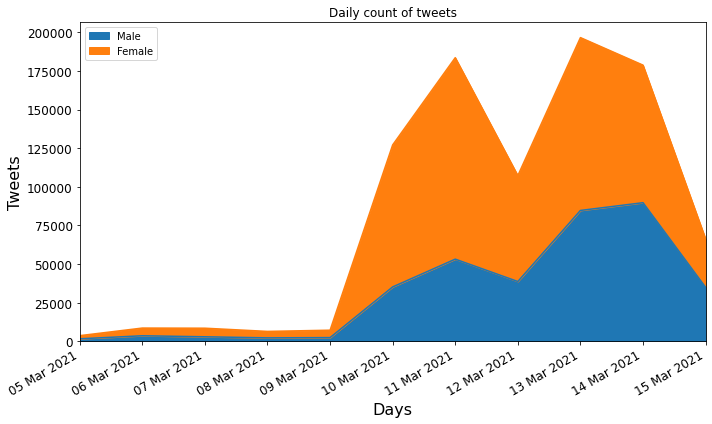

In [9]:
####Time series analysis - Figure 2A
import matplotlib.pyplot as plt

##Add in datetime column here for purposes of time series analysis
df_harass_selected_demog_VADER_NRC['datetime']= pd.to_datetime(df_harass_selected_demog_VADER_NRC['created_at'])

tweets = df_harass_selected_demog_VADER_NRC[['datetime', 'full_text_all']]
tweets_M = df_harass_selected_demog_VADER_NRC_M[['datetime', 'full_text_all']]
tweets_F = df_harass_selected_demog_VADER_NRC_F[['datetime', 'full_text_all']]

print(tweets.set_index("datetime").groupby(pd.Grouper(freq='D')).count())

daily_M = tweets_M.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
daily_F = tweets_F.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
daily_M = daily_M.rename(columns={'full_text_all':'Male'})
daily_F = daily_F.rename(columns={'full_text_all':'Female'})
daily_combined = pd.concat([daily_M, daily_F], axis=1)


import matplotlib.dates as mdates
plt.rcParams["figure.autolayout"] = True
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

ax = daily_combined.plot(kind='area',figsize=(10,6),title='Daily count of tweets')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
ax.set_xticks(daily_combined.index)
plt.gcf().autofmt_xdate()
plt.xlabel('Days', fontsize=16)
plt.ylabel('Tweets', fontsize=16)

plt.show()
#ax.get_figure().savefig('~/Figure 2A.pdf', format='pdf')


                           2 hourly moving average
datetime                                          
2021-03-10 02:02:51+00:00                -0.427821


Text(0, 0.5, 'VADER sentiment score')

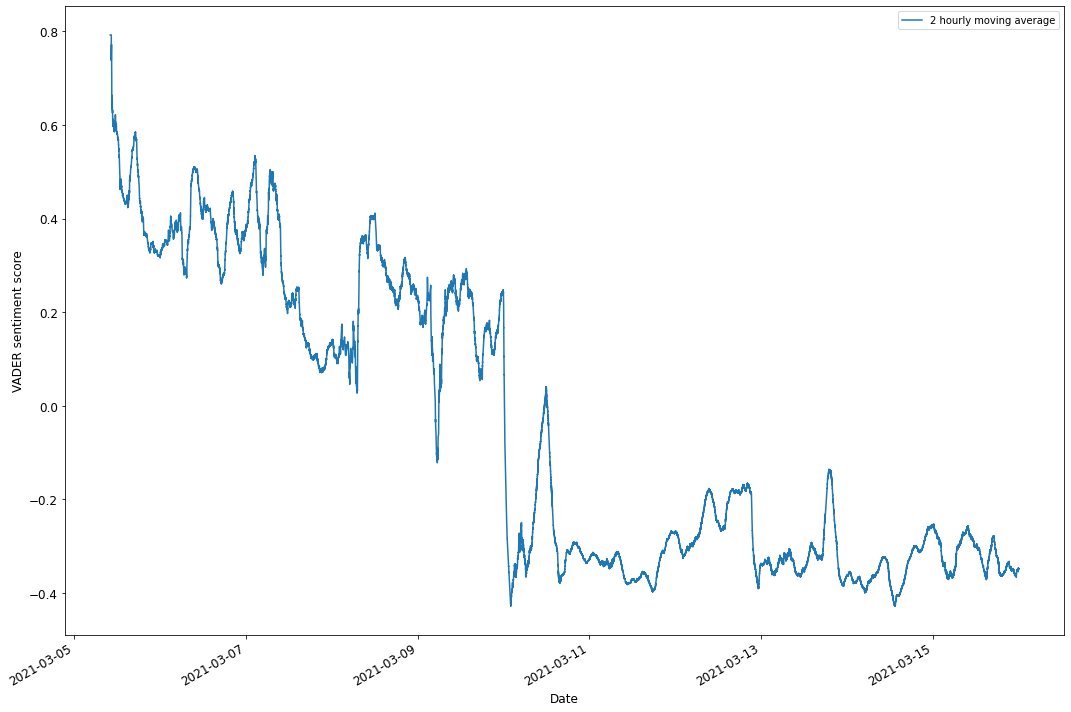

In [10]:
####Sentiment analysis - Figure 3B
df_moving_average_sentiment = df_harass_selected_demog_VADER_NRC[['datetime','text_compound']]
df_moving_average_sentiment = df_moving_average_sentiment.sort_values('datetime')
df_moving_average_sentiment['datetime_bin'] = df_moving_average_sentiment['datetime']
df_moving_average_sentiment.set_index('datetime', inplace=True)


df_moving_average_sentiment['2 hourly moving average'] = df_moving_average_sentiment.text_compound.rolling('2H').mean()
df_moving_average_sentiment2 = df_moving_average_sentiment[['2 hourly moving average']]

print(df_moving_average_sentiment2[df_moving_average_sentiment2['2 hourly moving average'] == df_moving_average_sentiment2['2 hourly moving average'].min()])
df_moving_average_sentiment2 = df_moving_average_sentiment2.rename(index = {'datetime': 'Date'})

import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(15, 10))
df_moving_average_sentiment2.plot(ax=axs)


axs.set_xlabel('Date', fontsize=12)
axs.set_ylabel('VADER sentiment score', fontsize=12)

#fig.savefig('~/Figure 3B.pdf', format='pdf')


In [11]:
####Summary stats - VADER scores by gender

from scipy import stats
from scipy.stats import ranksums

print(stats.shapiro(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC.Gender == 'Male'].text_compound))
print(stats.shapiro(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC.Gender == 'Female'].text_compound))
#p < 0.05 -> non-normal distribution
#ShapiroResult(statistic=0.9007903337478638, pvalue=0.0)
#ShapiroResult(statistic=0.903325617313385, pvalue=0.0)

#Hence get medians not means:
print(df_harass_selected_demog_VADER_NRC.groupby('Gender').text_compound.median())
#Female   -0.4404
#Male     -0.4767

#And test using Wilcoxon rank sum:
ranksums(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC.Gender == 'Male'].text_compound, df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC.Gender == 'Female'].text_compound)
#RanksumsResult(statistic=-21.96687472612101, pvalue=5.974041302924576e-107)

#############################

print((df_harass_selected_demog_VADER_NRC.text_compound >= 0.3).sum())
#179538
print((df_harass_selected_demog_VADER_NRC.text_compound <= -0.3).sum())
#493288

print((df_harass_selected_demog_VADER_NRC_M.text_compound >= 0.3).sum())
#66413
print((df_harass_selected_demog_VADER_NRC_M.text_compound <= -0.3).sum())
#198579

print((df_harass_selected_demog_VADER_NRC_F.text_compound >= 0.3).sum())
#113125
print((df_harass_selected_demog_VADER_NRC_F.text_compound <= -0.3).sum())
#294709

print('% Male tweets negative: ', (1-(66413 / (66413+198579)))*100)
print('% Female tweets negative: ',(1-(113125 / (113125+294709)))*100)

/home/chris/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9007903337478638, pvalue=0.0)
ShapiroResult(statistic=0.903325617313385, pvalue=0.0)
Gender
Female   -0.4404
Male     -0.4767
Name: text_compound, dtype: float64
179538
493288
66413
198579
113125
294709
% Male tweets negative:  74.93773396932737
% Female tweets negative:  72.26199875439517


In [12]:
####Summary stats - emotion analysis:
#{'anger': 0, 'joy': 1, 'fear': 2, 'sadness': 3}
print(df_harass_selected_demog_VADER_NRC.emotion_label.value_counts())
#2    517084
#0    197664
#3    119210
#1     60161

df_harass_selected_demog_VADER_NRC.groupby('Gender').emotion_label.value_counts()

2    517084
0    197664
3    119210
1     60161
Name: emotion_label, dtype: int64


Gender  emotion_label
Female  2                321676
        0                113043
        3                 69600
        1                 39978
Male    2                195408
        0                 84621
        3                 49610
        1                 20183
Name: emotion_label, dtype: int64

In [13]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

import numpy as np
obs = np.array([df_harass_selected_demog_VADER_NRC.groupby('Gender').emotion_label.value_counts()[0:4].tolist(), df_harass_selected_demog_VADER_NRC.groupby('Gender').emotion_label.value_counts()[4:8].tolist()])

stat, p, dof, expected = chi2_contingency(obs)
print(stat)
#2610.034148871483
print(p)
#0.0

2610.034148871483
0.0


<AxesSubplot:xlabel='Date', ylabel='Number of Tweets'>

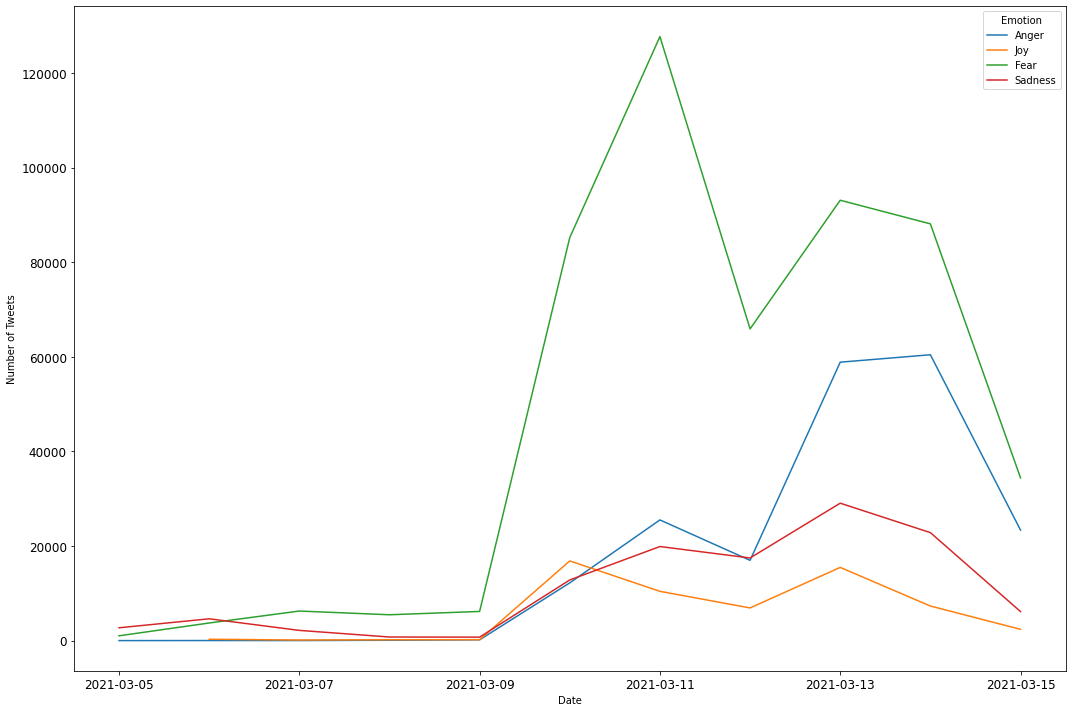

In [14]:
##Calculate daily moving averages for BERTemotion

df_moving_average_BERTemotion = df_harass_selected_demog_VADER_NRC[['datetime','emotion_label']]
df_moving_average_BERTemotion = df_moving_average_BERTemotion.sort_values('datetime')
#{'anger': 0, 'joy': 1, 'fear': 2, 'sadness': 3}
df_moving_average_BERTemotion_anger = df_moving_average_BERTemotion[df_moving_average_BERTemotion.emotion_label == '0']
df_moving_average_BERTemotion_joy = df_moving_average_BERTemotion[df_moving_average_BERTemotion.emotion_label == '1']
df_moving_average_BERTemotion_fear = df_moving_average_BERTemotion[df_moving_average_BERTemotion.emotion_label == '2']
df_moving_average_BERTemotion_sadness = df_moving_average_BERTemotion[df_moving_average_BERTemotion.emotion_label == '3']

df_moving_average_BERTemotion_anger = df_moving_average_BERTemotion_anger.rename(columns={'emotion_label':'Anger'})
df_moving_average_BERTemotion_joy = df_moving_average_BERTemotion_joy.rename(columns={'emotion_label':'Joy'})
df_moving_average_BERTemotion_fear = df_moving_average_BERTemotion_fear.rename(columns={'emotion_label':'Fear'})
df_moving_average_BERTemotion_sadness = df_moving_average_BERTemotion_sadness.rename(columns={'emotion_label':'Sadness'})

df_moving_average_BERTemotion_anger_dayTS = df_moving_average_BERTemotion_anger.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
df_moving_average_BERTemotion_joy_dayTS = df_moving_average_BERTemotion_joy.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
df_moving_average_BERTemotion_fear_dayTS = df_moving_average_BERTemotion_fear.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
df_moving_average_BERTemotion_sadness_dayTS = df_moving_average_BERTemotion_sadness.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
df_moving_average_BERTemotion_all_dayTS = pd.concat([df_moving_average_BERTemotion_anger_dayTS, df_moving_average_BERTemotion_joy_dayTS, df_moving_average_BERTemotion_fear_dayTS, df_moving_average_BERTemotion_sadness_dayTS], axis=1)
df_moving_average_BERTemotion_all_dayTS['Date'] = df_moving_average_BERTemotion_all_dayTS.index

##Daily emotion count - Figure 3A
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(15, 10))
sns.lineplot(x='Date', y='Number of Tweets', hue='Emotion', 
             data=pd.melt(df_moving_average_BERTemotion_all_dayTS, ['Date']).rename(columns={'value':'Number of Tweets', 'variable':'Emotion'}))

#save_plot.get_figure().savefig('~/Figure 3A.pdf', format='pdf')


In [15]:
##Now compare men vs women:
df_male = df_harass_selected_demog_VADER_NRC_M
df_female = df_harass_selected_demog_VADER_NRC_F

emotions = {'0' : 'anger', '1': 'joy', '2': 'fear','3': 'sadness'}
df_female.emotion_label_text = df_female['emotion_label'].map(emotions)
df_male.emotion_label_text = df_male['emotion_label'].map(emotions)

a = df_male.emotion_label_text.value_counts().rename_axis('Emotion_label').to_frame('Male_count')
b = df_female.emotion_label_text.value_counts().rename_axis('Emotion_label').to_frame('Female_count')
df_gender_emotions_count = a.merge(b, on='Emotion_label')
df_gender_emotions_count['Total'] = (df_gender_emotions_count.Female_count + df_gender_emotions_count.Male_count)
df_gender_emotions_count

/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


,Male_count,Female_count,Total
Emotion_label,,,
fear,195408,321676,517084
anger,84621,113043,197664
sadness,49610,69600,119210
joy,20183,39978,60161


#### Examine VADER scores stratified by emotion and gender

In [31]:
#{'anger': 0, 'joy': 1, 'fear': 2, 'sadness': 3}
#Examine VADER sentiments associated with each emotion
print(df_harass_selected_demog_VADER_NRC.groupby('emotion_label').text_compound.median())
#0   -0.6249
#1   -0.1027
#2   -0.4215
#3   -0.4576

emotion_label
0   -0.6249
1   -0.1027
2   -0.4215
3   -0.4576
Name: text_compound, dtype: float64


## LDA modelling <a name="chapter5"></a>

See SV_LDA_modelling_final.ipynb for full details on the LDA modelling fine-tuning process and then classification of individual Tweets into a topic category

In [19]:
df_harass_selected_demog_VADER_NRC_summary = df_harass_selected_demog_VADER_NRC
df_harass_selected_demog_VADER_NRC_summary['datetime']= pd.to_datetime(df_harass_selected_demog_VADER_NRC_summary['created_at'])

In [20]:
#Import the preprocessed df_harass_selected_demog_VADER_orig_tweets_classified (from SV_LDA_modelling_final.ipynb) 
#which includes classifications from the final LDA model used
import pandas as pd
import csv
dtypes_demog_VADER_orig_tweets={
        'created_at'  :  str, 'id'  :  str, 'full_text'  :  str, 'RT_full_text'  :  str, 'source'  :  str, 'is_quote_status'  :  str,
       'retweeted_status'  :  str, 'retweet_count'  :  float, 'favorite_count'  :  float, 'user_id_str'  :  str,
       'screen_name'  :  str, 'name'  :  str, 'description'  :  str, 'hashtags_all'  :  str, 'gender_male'  :  float,
       'gender_female'  :  float, 'age_<=18'  :  float, 'age_19-29'  :  float, 'age_30-39'  :  float, 'age_>=40'  :  float,
       'org_non-org'  :  float, 'org_is-org'  :  float, 'Gender'  :  str, 'Org?'  :  str, 'Age'  :  str,
       'text_banned' : str, 'full_text_VADER' : str, 'text_neg' : float, 'text_neu' : float, 'text_pos' : float,
       'text_compound' : float, 'text_banned_neg' : float, 'text_banned_neu' : float, 'text_banned_pos' : float,
       'text_banned_compound' : float, 'full_text_all' : str, 'RT_full_text' : str, 'RT_full_text_VADER' : str, 'datetime'  :  str, 
       'full_text_all_processed'  :  str, 'full_text_all_spacylemmatized' : str,
       'full_text_all_processed_token'  :  str, 'full_text_all_processed_no_stop'  :  str,
       'full_text_all_processed_no_stop2'  :  str,'Dominant_Topic' :str,
       'Topic_Perc_Contrib':str, 'Keywords':str,
       'full_text_all_processed_lemmatized' : str
       }
df_harass_selected_demog_VADER_orig_tweets_classified_chunk = pd.read_csv('~/Downloads/tweet-ids-001/SarahEverard/df_harass_selected_demog_VADER_orig_tweets_classified.csv',
     sep=',', 
     quotechar='"', 
     chunksize=100000,
     dtype=dtypes_demog_VADER_orig_tweets,
     index_col=0)
df_harass_selected_demog_VADER_orig_tweets_classified = pd.concat(df_harass_selected_demog_VADER_orig_tweets_classified_chunk)
df_harass_selected_demog_VADER_orig_tweets_classified.shape
#(121194, 58)


(121194, 58)

In [21]:
##Now take full_text_all column (from which the de-duplication to orig_tweets was taken)
#and Dominant_Topic, Topic_Perc_Contrib, Keywords and full_text_all_processed_lemmatized_y
#and merge with Mar_daily_full
#Then check that there are no null values for Dominant_Topic to confirm merge complete:
def merge_df_full(Mar_day_full, Mar_day_classified):
    Mar_day_classified = Mar_day_classified[['full_text_all', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'full_text_all_processed_lemmatized']]
    Mar_day_full_classified = pd.merge(Mar_day_full, Mar_day_classified, on='full_text_all', how='outer')
    #print((Mar_day_full_classified.full_text_all_processed_lemmatized_x != Mar_day_full_classified.full_text_all_processed_lemmatized_y).sum(), '; if 0, then full_text_all_processed_lemmatized column is the same in both dfs')
    print(Mar_day_full_classified.Dominant_Topic.isnull().sum(), 'rows without a dominant topic inferred')
    return Mar_day_full_classified

df_harass_selected_demog_VADER_NRC_summary_classified = merge_df_full(df_harass_selected_demog_VADER_NRC_summary, df_harass_selected_demog_VADER_orig_tweets_classified)

df_harass_selected_demog_VADER_NRC_summary_classified.shape
#(894119, 56)

0 rows without a dominant topic inferred


(894119, 56)

In [22]:
##Find out total number of tweets per topic - note that the topic number doesn't correspond to the pyLDAvis above!!
df_harass_selected_demog_VADER_NRC_summary_classified.Dominant_Topic.value_counts()
#0.0    450656
#3.0    157643
#2.0    138713
#5.0     58901
#4.0     44597
#1.0     33884
#6.0      9725

0.0    450656
3.0    157643
2.0    138713
5.0     58901
4.0     44597
1.0     33884
6.0      9725
Name: Dominant_Topic, dtype: int64

In [ ]:
'''Ordered by prevalence

Topic 1 [0] – ‘Not safe walking home’:
    • (0, '0.042*"woman" + 0.038*"not" + 0.026*"saraheverard" + 0.025*"sarah" + 0.023*"everard" + 0.021*"man" + 0.017*"walk" + 0.014*"home" + 0.010*"feel" + 0.010*"safe"')
    • 41% of tokens

Topic 2 [3] – ‘Sarah Everard murdered’:
    • (3, '0.024*"not" + 0.022*"saraheverard" + 0.022*"police" + 0.018*"sarah" + 0.017*"everard" + 0.012*"woman" + 0.010*"murder" + 0.008*"people" + 0.008*"metpoliceuk" + 0.008*"no"')
    • 20.8% of tokens	

Topic 3 [2] – ‘Police officer arrested’:
    • (2, '0.073*"police" + 0.070*"sarah" + 0.069*"everard" + 0.047*"officer" + 0.040*"arrest" + 0.024*"vigil" + 0.024*"met" + 0.023*"disappearance" + 0.019*"murder" + 0.017*"london"')
    • 15.6% of tokens	

Topic 4 [5] – ‘Sarah Everard vigil, peaceful protest’:
    • (5, '0.066*"vigil" + 0.051*"protest" + 0.049*"peaceful" + 0.038*"saraheverard" + 0.029*"woman" + 0.021*"not" + 0.018*"uk" + 0.018*"policing" + 0.018*"would" + 0.018*"need"')	
    • 8.3% of tokens

Topic 5 [4]– ‘Thoughts with Sarah Everard’s friends & family’:
    • (4, '0.065*"sarah" + 0.053*"everard" + 0.052*"family" + 0.021*"friend" + 0.018*"saraheverard" + 0.012*"pay" + 0.012*"thought" + 0.011*"love" + 0.010*"peace" + 0.010*"kate"')	
    • 6.5% of tokens

Topic 6 [1] – ‘Missing Wednesday 3 March, please share’: 
    • (1, '0.022*"saraheverard" + 0.016*"please" + 0.011*"march" + 0.010*"clapham" + 0.010*"share" + 0.008*"brixton" + 0.008*"3" + 0.007*"wednesday" + 0.007*"miss" + 0.007*"information"')	
    • 3.5% of tokens

Topic 7 [6] – ‘Tigray genocide’:
    • (6, '0.039*"saraheverard" + 0.033*"tigraygenocide" + 0.032*"mothersday" + 0.031*"tigraymothers" + 0.030*"tigray" + 0.029*"metoo" + 0.026*"un" + 0.023*"violenceagainstwomen" + 0.022*"rape" + 0.016*"bwoodward"')
    • 4.4% of tokens

'''

In [23]:
##For ease, create Dominant_topic_prev as topics ordered by prevalence:
df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic_prev'] = df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic']
df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic_prev'] = df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic_prev'].replace({
    '0.0' : '1',
    '3.0' : '2',
    '2.0' : '3',
    '5.0' : '4',
    '4.0' : '5',
    '1.0' : '6',
    '6.0' : '7',
})
df_harass_selected_demog_VADER_NRC_summary_classified.Dominant_Topic_prev.value_counts()

1    450656
2    157643
3    138713
4     58901
5     44597
6     33884
7      9725
Name: Dominant_Topic_prev, dtype: int64

In [24]:
topic_1_tweets = df_harass_selected_demog_VADER_NRC_summary_classified[df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic_prev']=='1']
topic_2_tweets = df_harass_selected_demog_VADER_NRC_summary_classified[df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic_prev']=='2']
topic_3_tweets = df_harass_selected_demog_VADER_NRC_summary_classified[df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic_prev']=='3']
topic_4_tweets = df_harass_selected_demog_VADER_NRC_summary_classified[df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic_prev']=='4']
topic_5_tweets = df_harass_selected_demog_VADER_NRC_summary_classified[df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic_prev']=='5']
topic_6_tweets = df_harass_selected_demog_VADER_NRC_summary_classified[df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic_prev']=='6']
topic_7_tweets = df_harass_selected_demog_VADER_NRC_summary_classified[df_harass_selected_demog_VADER_NRC_summary_classified['Dominant_Topic_prev']=='7']

topic_1_tweets_ts = topic_1_tweets[['datetime', 'full_text_all']]
topic_2_tweets_ts = topic_2_tweets[['datetime', 'full_text_all']]
topic_3_tweets_ts = topic_3_tweets[['datetime', 'full_text_all']]
topic_4_tweets_ts = topic_4_tweets[['datetime', 'full_text_all']]
topic_5_tweets_ts = topic_5_tweets[['datetime', 'full_text_all']]
topic_6_tweets_ts = topic_6_tweets[['datetime', 'full_text_all']]
topic_7_tweets_ts = topic_7_tweets[['datetime', 'full_text_all']]

'''
topic_1_tweets_ts = topic_1_tweets_ts.rename(columns={ 'full_text_all': 'topic_1'})
topic_2_tweets_ts = topic_2_tweets_ts.rename(columns={ 'full_text_all': 'topic_2'})
topic_3_tweets_ts = topic_3_tweets_ts.rename(columns={ 'full_text_all': 'topic_3'})
topic_4_tweets_ts = topic_4_tweets_ts.rename(columns={ 'full_text_all': 'topic_4'})
topic_5_tweets_ts = topic_5_tweets_ts.rename(columns={ 'full_text_all': 'topic_5'})
topic_6_tweets_ts = topic_6_tweets_ts.rename(columns={ 'full_text_all': 'topic_6'})
topic_7_tweets_ts = topic_7_tweets_ts.rename(columns={ 'full_text_all': 'topic_7'})
'''
topic_1_tweets_ts = topic_1_tweets_ts.rename(columns={ 'full_text_all': 'Not safe walking home'})
topic_2_tweets_ts = topic_2_tweets_ts.rename(columns={ 'full_text_all': 'Sarah Everard murdered'})
topic_3_tweets_ts = topic_3_tweets_ts.rename(columns={ 'full_text_all': 'Police officer arrested'})
topic_4_tweets_ts = topic_4_tweets_ts.rename(columns={ 'full_text_all': 'Sarah Everard vigil, peaceful protest'})
topic_5_tweets_ts = topic_5_tweets_ts.rename(columns={ 'full_text_all': 'Thoughts with Sarah Everard’s friends & family'})
topic_6_tweets_ts = topic_6_tweets_ts.rename(columns={ 'full_text_all': 'Missing Wednesday 3 March, please share'})
topic_7_tweets_ts = topic_7_tweets_ts.rename(columns={ 'full_text_all': 'Tigray genocide'})

topic_1_tweets_ts_count = topic_1_tweets_ts.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
topic_2_tweets_ts_count = topic_2_tweets_ts.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
topic_3_tweets_ts_count = topic_3_tweets_ts.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
topic_4_tweets_ts_count = topic_4_tweets_ts.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
topic_5_tweets_ts_count = topic_5_tweets_ts.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
topic_6_tweets_ts_count = topic_6_tweets_ts.set_index("datetime").groupby(pd.Grouper(freq='D')).count()
topic_7_tweets_ts_count = topic_7_tweets_ts.set_index("datetime").groupby(pd.Grouper(freq='D')).count()

topic_all_tweets_ts_count = pd.concat([
    topic_1_tweets_ts_count,
    topic_2_tweets_ts_count,
    topic_3_tweets_ts_count,
    topic_4_tweets_ts_count,
    topic_5_tweets_ts_count,
    topic_6_tweets_ts_count,
    topic_7_tweets_ts_count
], axis=1)

In [25]:
topic_all_tweets_ts_count = topic_all_tweets_ts_count.fillna('0')
topic_all_tweets_ts_count['datetime'] = topic_all_tweets_ts_count.index
topic_all_tweets_ts_count.index.names = ['Date']

##Save Table
#topic_all_tweets_ts_count.drop(columns = ['datetime']).to_csv('~/Table S11.csv')
topic_all_tweets_ts_count

,Not safe walking home,Sarah Everard murdered,Police officer arrested,"Sarah Everard vigil, peaceful protest",Thoughts with Sarah Everard’s friends & family,"Missing Wednesday 3 March, please share",Tigray genocide,datetime
Date,,,,,,,,
2021-03-05 00:00:00+00:00,410,2,279,0,8,3034,0,2021-03-05 00:00:00+00:00
2021-03-06 00:00:00+00:00,1875,9,765,0,54,5947,0,2021-03-06 00:00:00+00:00
2021-03-07 00:00:00+00:00,1290,29,573,0,51,6611,0,2021-03-07 00:00:00+00:00
2021-03-08 00:00:00+00:00,1371,28,455,1.0,112,4518,0,2021-03-08 00:00:00+00:00
2021-03-09 00:00:00+00:00,2384,44,1044,0.0,68,3724,3.0,2021-03-09 00:00:00+00:00
2021-03-10 00:00:00+00:00,101475,4233,17462,469.0,2188,1266,11.0,2021-03-10 00:00:00+00:00
2021-03-11 00:00:00+00:00,152525,12721,10084,1436.0,4392,2048,331.0,2021-03-11 00:00:00+00:00
2021-03-12 00:00:00+00:00,68290,11039,17809,3066.0,5486,1343,227.0,2021-03-12 00:00:00+00:00
2021-03-13 00:00:00+00:00,57896,44535,40506,32816.0,18296,2341,129.0,2021-03-13 00:00:00+00:00


/home/chris/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of tweets')

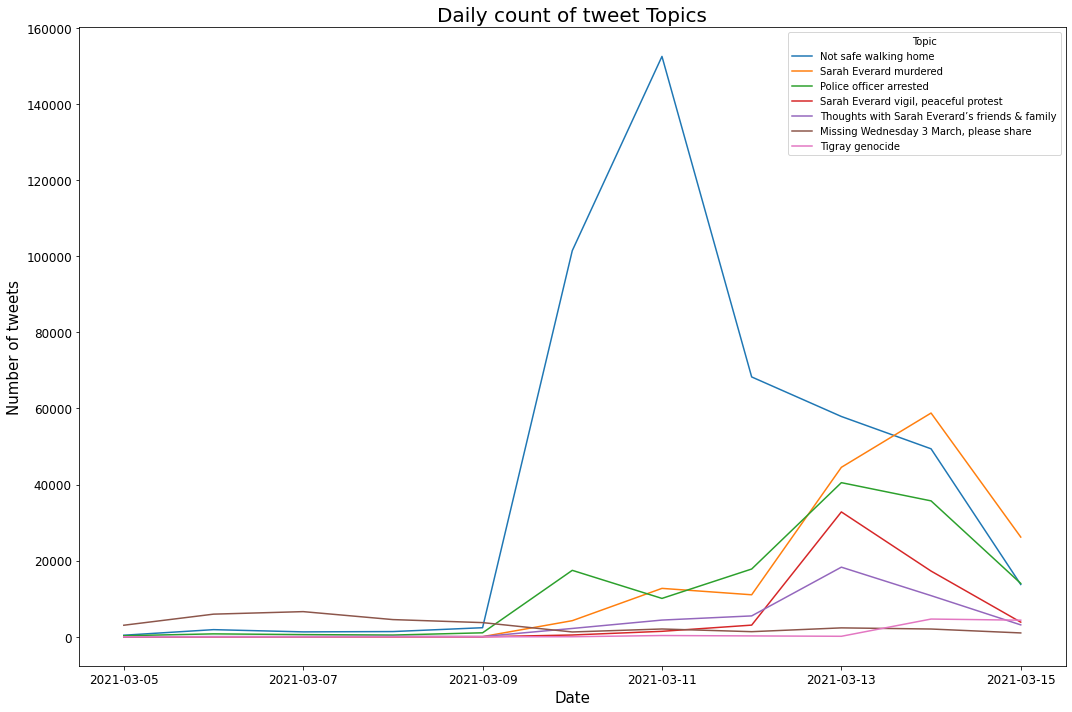

In [26]:
###Create time series figure 2B
topic_all_tweets_ts_count_plot = pd.melt(topic_all_tweets_ts_count, 'datetime', var_name='Topic', value_name='count')

import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot('datetime', 'count', hue='Topic',
              data=topic_all_tweets_ts_count_plot)
ax.invert_yaxis()
plt.title('Daily count of tweet Topics', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of tweets', fontsize=15)

##Save as Figure 2A
#plt.savefig('~/Figure 2B.pdf', format='pdf')


In [27]:
###Get gender stats across all tweets (including multiple tweets from same user)
print('Get gender stats across all tweets (including multiple tweets from same user): \n')
def value_counts_percent_female(x):
    return "{:.1f}".format(100* x.Gender.value_counts().Female / (x.Gender.value_counts().Female + x.Gender.value_counts().Male))
print('Topic 1:', topic_1_tweets.Gender.value_counts().Female, 'Female to ', topic_1_tweets.Gender.value_counts().Male, 'Male;  ', value_counts_percent_female(topic_1_tweets), '% Female')
print('Topic 2:', topic_2_tweets.Gender.value_counts().Female, 'Female to ', topic_2_tweets.Gender.value_counts().Male, 'Male;  ', value_counts_percent_female(topic_2_tweets), '% Female')
print('Topic 3:', topic_3_tweets.Gender.value_counts().Female, 'Female to ', topic_3_tweets.Gender.value_counts().Male, 'Male;  ', value_counts_percent_female(topic_3_tweets), '% Female')
print('Topic 4:', topic_4_tweets.Gender.value_counts().Female, 'Female to ', topic_4_tweets.Gender.value_counts().Male, 'Male;  ', value_counts_percent_female(topic_4_tweets), '% Female')
print('Topic 5:', topic_5_tweets.Gender.value_counts().Female, 'Female to ', topic_5_tweets.Gender.value_counts().Male, 'Male;  ', value_counts_percent_female(topic_5_tweets), '% Female')
print('Topic 6:', topic_6_tweets.Gender.value_counts().Female, 'Female to ', topic_6_tweets.Gender.value_counts().Male, 'Male;  ', value_counts_percent_female(topic_6_tweets), '% Female')
print('Topic 7:', topic_7_tweets.Gender.value_counts().Female, 'Female to ', topic_7_tweets.Gender.value_counts().Male, 'Male;  ', value_counts_percent_female(topic_7_tweets), '% Female')

Get gender stats across all tweets (including multiple tweets from same user): 

Topic 1: 316259 Female to  134397 Male;   70.2 % Female
Topic 2: 75502 Female to  82141 Male;   47.9 % Female
Topic 3: 68398 Female to  70315 Male;   49.3 % Female
Topic 4: 34600 Female to  24301 Male;   58.7 % Female
Topic 5: 26300 Female to  18297 Male;   59.0 % Female
Topic 6: 20526 Female to  13358 Male;   60.6 % Female
Topic 7: 2712 Female to  7013 Male;   27.9 % Female


## Hashtag analysis <a name="chapter6"></a>

In [20]:
##Hashtag analysis

#Note the below is how 'hashtags_all' in df_harass_selected_demog_VADER_NRC imported at the top was created
#from original tweet df (df_harass_selected_demog_VADER_NRC no longer contains 'entities' to save space):

import ast
from tqdm import tqdm
tqdm.pandas()

df_harass_selected_demog_VADER_NRC['entities'] = df_harass_selected_demog_VADER_NRC.entities.progress_apply(ast.literal_eval)
df_harass_selected_demog_VADER_NRC['hashtags'] = df_harass_selected_demog_VADER_NRC['entities'].progress_apply(lambda x: x.get('hashtags'))
def list_dict_to_hashtag(x):
    return [y['text'] for y in x if 'text' in y]
df_harass_all['hashtags_all'] = df_harass_all['hashtags'].progress_apply(lambda x: list_dict_to_hashtag(x))

100%|███████████████████████████████| 894119/894119 [00:08<00:00, 110440.79it/s]


'##Check the above code:\ntest_hashtags = pd.read_csv(\'/home/chris/Downloads/tweet-ids-001/SarahEverard/test_hashtags.csv\', sep=\',\', quotechar=\'"\')\ntest_hashtags[\'id\'] = test_hashtags[\'id_str\'].astype(str)\ntest_hashtags_merged = test_hashtags.merge(df_harass_selected_demog_VADER_NRC, on=\'id\')\n(test_hashtags_merged[\'hashtags_all_x\'] != test_hashtags_merged[\'hashtags_all_y\']).sum()\n#2 - not sure what happened here; tweet text appears to be the same. Happy to leave it as only 2\n#and hashtags are [\'SarahEverard\'] and []\npd.set_option(\'display.max_colwidth\', None)\n(test_hashtags_merged[test_hashtags_merged[\'hashtags_all_x\'] != test_hashtags_merged[\'hashtags_all_y\']]).hashtags_all_y\n#On closer inspection, the second one of these clearly isn\'t a hashtag - may be due to the manual input error above\n#=> Indeed, the id matches (1370920433957040129)\n'

In [8]:
###Start hashtag analysis from here
def flatten(df, col):
    col_flat = pd.DataFrame([[i, x] for i, y in df[col].apply(list).iteritems() for x in y], columns=['I', col])
    col_flat = col_flat.set_index('I')  
    return col_flat


df_harass_selected_demog_VADER_NRC.hashtags_all = df_harass_selected_demog_VADER_NRC.hashtags_all.apply(lambda x: x.replace('I was Spoono, the cyrix chip used, aids tested neg.-TheJeeneBraaveSportsClubljp-loveisNeedasWant-the family is there by law-the government is taxation for me-', '[]'))
df_harass_selected_demog_VADER_NRC['hashtags_all'] =  df_harass_selected_demog_VADER_NRC.hashtags_all.progress_apply(ast.literal_eval)


##Get a list of all hashtags
hashtags_all_list = flatten(df_harass_selected_demog_VADER_NRC, 'hashtags_all')
##Get value_counts() of all hashtags to identify most frequent
df_rank_hashtags = pd.DataFrame(hashtags_all_list.value_counts())

##Convert all hashtags to lowercase to get more representative value_counts
hashtags_all_list_lowercase = hashtags_all_list
hashtags_all_list_lowercase = hashtags_all_list_lowercase.apply(lambda x: x.astype(str).str.lower())
df_rank_hashtags_lowercase = pd.DataFrame(hashtags_all_list_lowercase.value_counts().rename_axis('Hashtags').reset_index(name='count'))

##Get gender differences in use of top 30 hashtags
top_30_hashtags = df_rank_hashtags_lowercase.iloc[0:30,0]
top_30_hashtags_male = []
top_30_hashtags_female = []

df_harass_selected_demog_VADER_NRC['hashtags_all_lower'] = df_harass_selected_demog_VADER_NRC['hashtags_all'].astype(str)
df_harass_selected_demog_VADER_NRC['hashtags_all_lower'] = df_harass_selected_demog_VADER_NRC['hashtags_all_lower'].apply(lambda x: x.lower())
for hashtag in top_30_hashtags:
    female_count = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['hashtags_all_lower'].str.contains(fr'{hashtag}\b', na=False, regex=True) == True].Gender.value_counts().Female
    top_30_hashtags_female.append(female_count)
    male_count = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['hashtags_all_lower'].str.contains(fr'{hashtag}\b', na=False, regex=True) == True].Gender.value_counts().Male
    top_30_hashtags_male.append(male_count)
count_data = {'Hashtags' :top_30_hashtags, 'Male_count' : top_30_hashtags_male, 'Female_count' : top_30_hashtags_female}
df_top_30_hashtags_count = pd.DataFrame(count_data)
df_top_30_hashtags_count['Percent_female'] = (df_top_30_hashtags_count['Female_count'] / (df_top_30_hashtags_count['Female_count'] + df_top_30_hashtags_count['Male_count']))*100

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 894119/894119 [00:04<00:00, 204347.67it/s]


In [78]:
df_top_30_hashtags_count

,Hashtags,Male_count,Female_count,Percent_female
0,saraheverard,72910,120376,62.278696
1,reclaimthesestreets,13192,21157,61.594224
2,claphamcommon,10922,15495,58.655411
3,notallmen,5156,11161,68.401054
4,missing,3906,6324,61.818182
5,metoo,4886,4752,49.304835
6,reclaimthestreets,2852,5952,67.605634
7,brixton,2909,4824,62.381999
8,shewasjustwalkinghome,1595,5065,76.051051
9,violenceagainstwomen,4383,2329,34.699046


In [22]:
####Start hashtag analysis BY TOPIC here:
def hashtag_analysis_by_topic(df):
    ###Start hashtag analysis from here
    def flatten(df, col):
        col_flat = pd.DataFrame([[i, x] for i, y in df[col].apply(list).iteritems() for x in y], columns=['I', col])
        col_flat = col_flat.set_index('I')  
        return col_flat
    #df.hashtags_all = df.hashtags_all.apply(lambda x: x.replace('I was Spoono, the cyrix chip used, aids tested neg.-TheJeeneBraaveSportsClubljp-loveisNeedasWant-the family is there by law-the government is taxation for me-', '[]'))
    #df['hashtags_all'] =  df.hashtags_all.progress_apply(ast.literal_eval)
    ##Get a list of all hashtags
    hashtags_all_list = flatten(df, 'hashtags_all')
    ##Get value_counts() of all hashtags to identify most frequent
    df_rank_hashtags = pd.DataFrame(hashtags_all_list.value_counts())

    ##Convert all hashtags to lowercase to get more representative value_counts
    hashtags_all_list_lowercase = hashtags_all_list
    hashtags_all_list_lowercase = hashtags_all_list_lowercase.apply(lambda x: x.astype(str).str.lower())
    df_rank_hashtags_lowercase = pd.DataFrame(hashtags_all_list_lowercase.value_counts().rename_axis('Hashtags').reset_index(name='count'))

    ##Get gender differences in use of top 20 hashtags
    top_20_hashtags = df_rank_hashtags_lowercase.iloc[0:20,0]
    top_20_hashtags_male = []
    top_20_hashtags_female = []

    df['hashtags_all_lower'] = df['hashtags_all'].astype(str)
    df['hashtags_all_lower'] = df['hashtags_all_lower'].apply(lambda x: x.lower())
    for hashtag in top_20_hashtags:
        female_count = df[df['hashtags_all_lower'].str.contains(fr'{hashtag}\b', na=False, regex=True) == True].Gender.value_counts().Female
        top_20_hashtags_female.append(female_count)
        male_count = df[df['hashtags_all_lower'].str.contains(fr'{hashtag}\b', na=False, regex=True) == True].Gender.value_counts().Male
        top_20_hashtags_male.append(male_count)
    count_data = {'Hashtags' :top_20_hashtags, 'Male_count' : top_20_hashtags_male, 'Female_count' : top_20_hashtags_female}
    df_top_20_hashtags_count = pd.DataFrame(count_data)
    df_top_20_hashtags_count['Percent_female'] = (df_top_20_hashtags_count['Female_count'] / (df_top_20_hashtags_count['Female_count'] + df_top_20_hashtags_count['Male_count']))*100
    return df_top_20_hashtags_count

topic_1_tweets_top_20_hashtags_count = hashtag_analysis_by_topic(topic_1_tweets)
topic_2_tweets_top_20_hashtags_count = hashtag_analysis_by_topic(topic_2_tweets)
topic_3_tweets_top_20_hashtags_count = hashtag_analysis_by_topic(topic_3_tweets)
topic_4_tweets_top_20_hashtags_count = hashtag_analysis_by_topic(topic_4_tweets)
topic_5_tweets_top_20_hashtags_count = hashtag_analysis_by_topic(topic_5_tweets)
topic_6_tweets_top_20_hashtags_count = hashtag_analysis_by_topic(topic_6_tweets)
topic_7_tweets_top_20_hashtags_count = hashtag_analysis_by_topic(topic_7_tweets)

/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
topic_1_tweets_top_20_hashtags_count

,Hashtags,Male_count,Female_count,Percent_female
0,saraheverard,27547,66425,70.685949
1,notallmen,5024,11018,68.682209
2,toomanywomen,1404,4183,74.870234
3,metoo,1723,3487,66.928983
4,reclaimthestreets,1295,3744,74.300456
5,shewaswalkinghome,1144,3339,74.481374
6,shewasjustwalkinghome,946,3390,78.182657
7,notallmenbutallwomen,846,2713,76.229278
8,enoughisenough,765,2694,77.883781
9,reclaimthesestreets,879,2552,74.380647


In [41]:
topic_2_tweets_top_20_hashtags_count

,Hashtags,Male_count,Female_count,Percent_female
0,saraheverard,17131,15924,48.174255
1,reclaimthesestreets,2188,2293,51.171613
2,sarah,1849,2722,59.549333
3,claphamcommon,1899,1693,47.132517
4,metpolice,717,541,43.004769
5,clapham,809,432,34.810637
6,reclaimthestreets,566,621,52.316765
7,pritipatel,647,435,40.203327
8,saraheverardvigil,437,284,39.389736
9,shameonyou,386,329,46.013986


In [42]:
topic_3_tweets_top_20_hashtags_count

,Hashtags,Male_count,Female_count,Percent_female
0,saraheverard,3733,3857,50.816864
1,reclaimthesestreets,988,1019,50.772297
2,claphamcommon,820,634,43.603851
3,breaking,479,295,38.113695
4,reclaimthestreets,337,334,49.776453
5,london,373,260,41.074250
6,reclaimthenight,298,305,50.580431
7,clapham,179,141,44.062500
8,live,133,137,50.740741
9,livestream,126,131,50.972763


In [43]:
topic_4_tweets_top_20_hashtags_count

,Hashtags,Male_count,Female_count,Percent_female
0,saraheverard,12355,18943,60.524634
1,reclaimthesestreets,8888,14733,62.372465
2,claphamcommon,7643,12106,61.299306
3,policingbill,1374,1370,49.927114
4,heymp,1329,1323,49.886878
5,reclaimthenight,491,1462,74.859191
6,reclaimthestreets,489,867,63.938053
7,shewasjustwalkinghome,157,482,75.430360
8,arrestyourown,189,413,68.604651
9,shameonyou,185,414,69.115192


In [44]:
topic_5_tweets_top_20_hashtags_count

,Hashtags,Male_count,Female_count,Percent_female
0,saraheverard,3505,6892,66.288352
1,shewasjustwalkinghome,362,977,72.964899
2,gethomesafe,280,686,71.014493
3,wearehere,280,683,70.924195
4,reclaimthesestreets,134,352,72.427984
5,claphamcommon,164,276,62.727273
6,reclaimthestreets,106,267,71.581769
7,duchessofcambridge,138,176,56.050955
8,ripsaraheverard,54,91,62.758621
9,reclaimthenight,24,113,82.481752


In [45]:
topic_6_tweets_top_20_hashtags_count

,Hashtags,Male_count,Female_count,Percent_female
0,saraheverard,3837,6580,63.165979
1,missing,3819,6225,61.977300
2,brixton,2881,4778,62.384123
3,appeal,646,887,57.860404
4,claphamjunction,224,479,68.136558
5,clapham,177,426,70.646766
6,reclaimthesestreets,107,175,62.056738
7,claphamcommon,90,148,62.184874
8,reclaimthestreets,54,83,60.583942
9,freehaiti,85,29,25.438596


In [46]:
topic_7_tweets_top_20_hashtags_count

,Hashtags,Male_count,Female_count,Percent_female
0,saraheverard,4802,1755,26.765289
1,violenceagainstwomen,3959,1352,25.456600
2,tigraygenocide,3856,1331,25.660305
3,tigraymothers,3718,1306,25.995223
4,mothersday,3373,1181,25.933245
5,metoo,3068,1093,26.267724
6,tigray,3061,1061,25.739932
7,sgbv,772,286,27.032136
8,women,4548,1564,25.589005
9,mothersday2021,544,192,26.086957


In [53]:
top_20_hashtags_count_list = [topic_1_tweets_top_20_hashtags_count, topic_2_tweets_top_20_hashtags_count, topic_3_tweets_top_20_hashtags_count, topic_4_tweets_top_20_hashtags_count, topic_5_tweets_top_20_hashtags_count, topic_6_tweets_top_20_hashtags_count, topic_7_tweets_top_20_hashtags_count]
concat_top_20_hashtags_count = pd.DataFrame()
for top_20_hashtags_count in top_20_hashtags_count_list:
    top_20_hashtags_count = top_20_hashtags_count.loc[0:10]
    concat_top_20_hashtags_count = pd.concat([concat_top_20_hashtags_count, top_20_hashtags_count], axis=1)

#Save Table 4
#concat_top_20_hashtags_count.to_csv('~/df_per_topic_top_20_hashtags_count.csv', sep=',', quotechar='"')

## Age analysis (Table 2) <a name="chapter7"></a>

In [ ]:
'''Ordered by prevalence

Topic 1 [0] – ‘Not safe walking home’:
    • (0, '0.042*"woman" + 0.038*"not" + 0.026*"saraheverard" + 0.025*"sarah" + 0.023*"everard" + 0.021*"man" + 0.017*"walk" + 0.014*"home" + 0.010*"feel" + 0.010*"safe"')
    • 41% of tokens

Topic 2 [3] – ‘Sarah Everard murdered’:
    • (3, '0.024*"not" + 0.022*"saraheverard" + 0.022*"police" + 0.018*"sarah" + 0.017*"everard" + 0.012*"woman" + 0.010*"murder" + 0.008*"people" + 0.008*"metpoliceuk" + 0.008*"no"')
    • 20.8% of tokens	

Topic 3 [2] – ‘Police officer arrested’:
    • (2, '0.073*"police" + 0.070*"sarah" + 0.069*"everard" + 0.047*"officer" + 0.040*"arrest" + 0.024*"vigil" + 0.024*"met" + 0.023*"disappearance" + 0.019*"murder" + 0.017*"london"')
    • 15.6% of tokens	

Topic 4 [5] – ‘Sarah Everard vigil, peaceful protest’:
    • (5, '0.066*"vigil" + 0.051*"protest" + 0.049*"peaceful" + 0.038*"saraheverard" + 0.029*"woman" + 0.021*"not" + 0.018*"uk" + 0.018*"policing" + 0.018*"would" + 0.018*"need"')	
    • 8.3% of tokens

Topic 5 [4]– ‘Thoughts with Sarah Everard’s friends & family’:
    • (4, '0.065*"sarah" + 0.053*"everard" + 0.052*"family" + 0.021*"friend" + 0.018*"saraheverard" + 0.012*"pay" + 0.012*"thought" + 0.011*"love" + 0.010*"peace" + 0.010*"kate"')	
    • 6.5% of tokens

Topic 6 [1] – ‘Missing Wednesday 3 March, please share’: 
    • (1, '0.022*"saraheverard" + 0.016*"please" + 0.011*"march" + 0.010*"clapham" + 0.010*"share" + 0.008*"brixton" + 0.008*"3" + 0.007*"wednesday" + 0.007*"miss" + 0.007*"information"')	
    • 3.5% of tokens

Topic 7 [6] – ‘Tigray genocide’:
    • (6, '0.039*"saraheverard" + 0.033*"tigraygenocide" + 0.032*"mothersday" + 0.031*"tigraymothers" + 0.030*"tigray" + 0.029*"metoo" + 0.026*"un" + 0.023*"violenceagainstwomen" + 0.022*"rape" + 0.016*"bwoodward"')
    • 4.4% of tokens

'''

age_19-29    314787
age_>=40     270340
age_30-39    154543
age_<=18     154449
Name: Age, dtype: int64


<AxesSubplot:>

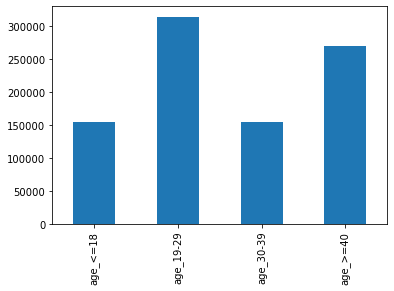

In [73]:
print(df_harass_selected_demog_VADER_NRC_summary_classified.Age.value_counts())
df_harass_selected_demog_VADER_NRC_summary_classified.Age.value_counts().reindex(index = ['age_<=18', 'age_19-29', 'age_30-39', 'age_>=40']).plot.bar()

In [14]:
df_harass_selected_demog_VADER_NRC_summary_classified.groupby('Dominant_Topic_prev')['Age'].value_counts()

Dominant_Topic_prev  Age      
1                    age_19-29    182916
                     age_>=40     105374
                     age_<=18      87143
                     age_30-39     75223
2                    age_>=40      66701
                     age_19-29     41947
                     age_30-39     26527
                     age_<=18      22468
3                    age_>=40      48099
                     age_19-29     43012
                     age_30-39     24606
                     age_<=18      22996
4                    age_>=40      20512
                     age_19-29     18906
                     age_30-39     10718
                     age_<=18       8765
5                    age_>=40      15890
                     age_19-29     13682
                     age_30-39      8550
                     age_<=18       6475
6                    age_>=40      11359
                     age_19-29     11074
                     age_30-39      7450
                     age_<

In [16]:
df_harass_selected_demog_VADER_NRC_summary_classified.groupby('Gender')['Age'].value_counts()

Gender  Age      
Female  age_19-29    227081
        age_>=40     119887
        age_<=18      99702
        age_30-39     97627
Male    age_>=40     150453
        age_19-29     87706
        age_30-39     56916
        age_<=18      54747
Name: Age, dtype: int64

In [17]:
df_harass_selected_demog_VADER_NRC_summary_classified.groupby(['Gender', 'Dominant_Topic_prev'])['Age'].value_counts()

Gender  Dominant_Topic_prev  Age      
Female  1                    age_19-29    145306
                             age_<=18      62752
                             age_>=40      54840
                             age_30-39     53361
        2                    age_19-29     25067
                             age_>=40      24327
                             age_30-39     13863
                             age_<=18      12245
        3                    age_19-29     25520
                             age_>=40      17877
                             age_30-39     12839
                             age_<=18      12162
        4                    age_19-29     12968
                             age_>=40       9542
                             age_30-39      6676
                             age_<=18       5414
        5                    age_19-29      9341
                             age_>=40       7371
                             age_30-39      5605
                             a

## User sample 2000 (M3inference manual validation)  <a name="chapter8"></a>

In [2]:
###Initial (individual) dataset:
import pandas as pd

##Import unique_users_2000
unique_users_2000 = pd.read_csv('~/Downloads/tweet-ids-001/SarahEverard/unique_users_2000.csv',
     sep=',', 
     quotechar='"', 
     index_col=0)

##Import unique_users_2000_edited
unique_users_2000_edited = pd.read_csv('~/Downloads/tweet-ids-001/SarahEverard/unique_users_2000_edited.csv',
     sep=',', 
     quotechar='"', 
     index_col=0)

unique_users_2000_editedCH = pd.read_csv('/home/chris/Downloads/tweet-ids-001/SarahEverard/CH-unique_users_2000_edited.csv',
     sep=',', 
     quotechar='"', 
     index_col=0)

#Rename column 5 and 6 -> Gender_guessed and Gender_specified
unique_users_2000_edited.rename(columns={ unique_users_2000_edited.columns[4]: "Gender_guessed_CW" }, inplace = True)
unique_users_2000_edited.rename(columns={ unique_users_2000_edited.columns[5]: "Gender_specified_CW" }, inplace = True)
unique_users_2000_editedCH.rename(columns={ unique_users_2000_editedCH.columns[4]: "Gender_guessed_CH" }, inplace = True)
unique_users_2000_editedCH.rename(columns={ unique_users_2000_editedCH.columns[5]: "Gender_specified_CH" }, inplace = True)
unique_users_2000.rename(columns={ unique_users_2000.columns[13]: "Org" }, inplace = True)

print(unique_users_2000_edited.screen_name.nunique())
print(unique_users_2000_editedCH.screen_name.nunique())
#2000 for both

#Inner join
unique_users_edited = pd.merge(unique_users_2000_edited[['user_id_str', 'screen_name', 'name', 'description', 'Gender_guessed_CW', 'Gender_specified_CW']],unique_users_2000_editedCH[['user_id_str', 'screen_name', 'name', 'Gender_guessed_CH', 'Gender_specified_CH']], on='screen_name')
print((unique_users_edited.name_x == unique_users_edited.name_y).sum())
#2000
print((unique_users_edited.user_id_str_x == unique_users_edited.user_id_str_y).sum())
#1465 - ignore this as likely due to str/int error
unique_users_edited['Gender_guessed_match'] = unique_users_edited.Gender_guessed_CW == unique_users_edited.Gender_guessed_CH

unique_users_edited['Gender_specified_CW'] = unique_users_edited['Gender_specified_CW'].fillna('nan')
unique_users_edited['Gender_specified_CH'] = unique_users_edited['Gender_specified_CH'].fillna('nan')
unique_users_edited['Gender_specified_match'] = unique_users_edited.Gender_specified_CW == unique_users_edited.Gender_specified_CH
unique_users_edited = unique_users_edited.drop(columns = ['name_y', 'user_id_str_y'])

#######============================================


2000
2000
2000
1465


##### Re-import:

In [2]:
import pandas as pd
##Get classified users:
unique_users_FINAL = pd.read_csv('~/Downloads/tweet-ids-001/SarahEverard/unique_users_edited_final_FINAL.csv',
     sep=',', 
     quotechar='"', 
     index_col=0)
unique_users_FINAL.screen_name = unique_users_FINAL.screen_name.astype(str)
#One screen_name is a number '09072021' - need to add the first 0 back to it
unique_users_FINAL = unique_users_FINAL.replace('9072021', '09072021')

##Get inferred users:
unique_users_inferred = pd.read_csv('/home/chris/Downloads/tweet-ids-001/SarahEverard/unique_users_2000.csv',
     sep=',', 
     quotechar='"', 
     index_col=0)
unique_users_inferred.screen_name = unique_users_inferred.screen_name.astype(str)

In [16]:
unique_users_FINAL_merged = unique_users_FINAL.merge(unique_users_inferred[['screen_name', 'name', 'description', 'Gender']], on='screen_name', how='outer')
print(unique_users_FINAL_merged.screen_name.nunique())
#2000

unique_users_FINAL_merged['Gender'] = unique_users_FINAL_merged['Gender'].replace('Female', 'F')
unique_users_FINAL_merged['Gender'] = unique_users_FINAL_merged['Gender'].replace('Male', 'M')

2000


In [35]:
##Cohen's kappa score - Gender_guessed, CW vs CH
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(unique_users_FINAL_merged.Gender_guessed_CW, unique_users_FINAL_merged.Gender_guessed_CH))
#0.7883499200230302

##Cohen's kappa score - Gender_guessed, CW vs Gender_guessed_FINAL
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(unique_users_FINAL_merged.Gender_guessed_CW, unique_users_FINAL_merged.Gender_guessed_final_FINAL))
#0.7669460218277004

##Cohen's kappa score - Gender_guessed, CH vs Gender_guessed_FINAL
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(unique_users_FINAL_merged.Gender_guessed_CH, unique_users_FINAL_merged.Gender_guessed_final_FINAL))
#0.7812235539131305

##Cohen's kappa score - Gender_guessed_FINAL vs Gender (from m3 inference)
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(unique_users_FINAL_merged.Gender_guessed_final_FINAL, unique_users_FINAL_merged.Gender))
#0.7203504172640853

0.7883499200230302
0.7669460218277004
0.7812235539131305
0.7203504172640853


In [ ]:
##Number of users where inferred and classified genders are the same
print('Number of users where inferred and classified genders are the same:', (unique_users_FINAL_merged['Gender_guessed_final_FINAL']==unique_users_FINAL_merged['Gender']).sum())
#1709

##### Gender specified dataset:


In [20]:
###Gender specified dataset:
unique_users_FINAL_merged_specified = unique_users_FINAL_merged[unique_users_FINAL_merged.Gender_specified_final_FINAL.notnull()]
##Number of users where inferred and classified genders are the same
print('Number of users with correct gender inferred',(unique_users_FINAL_merged_specified['Gender_guessed_final_FINAL']==unique_users_FINAL_merged_specified['Gender']).sum())
print('Number of users with gender specified:', len(unique_users_FINAL_merged_specified))

##Inspect those which are not:
unique_users_FINAL_merged_specified_wrong = unique_users_FINAL_merged_specified[~(unique_users_FINAL_merged_specified['Gender_guessed_final_FINAL']==unique_users_FINAL_merged_specified['Gender'])]
#How many of these 17 were not M or F
print(unique_users_FINAL_merged_specified_wrong['Gender_specified_final_FINAL'].value_counts())
#F    8, O    5; M    3; G    1

Number of users with correct gender inferred 432
Number of users with gender specified: 449
F    8
O    5
M    3
G    1
Name: Gender_specified_final_FINAL, dtype: int64


In [33]:
print(unique_users_FINAL_merged_specified.shape)
#(449, 18)

##Cohen's kappa score - Gender_specified, CW vs CH
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(unique_users_FINAL_merged_specified.Gender_guessed_CW, unique_users_FINAL_merged_specified.Gender_guessed_CH))
#0.8367532438021223

##Cohen's kappa score - Gender_specified, CW vs Gender_specified_FINAL
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(unique_users_FINAL_merged_specified.Gender_guessed_CW, unique_users_FINAL_merged_specified.Gender_guessed_final_FINAL))
#0.9106708173392004

##Cohen's kappa score - Gender_specified, CH vs Gender_specified_FINAL
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(unique_users_FINAL_merged_specified.Gender_guessed_CH, unique_users_FINAL_merged_specified.Gender_guessed_final_FINAL))
#0.9108211047761473


##Cohen's kappa score - Gender_specified_FINAL vs Gender (from m3 inference)
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(unique_users_FINAL_merged_specified.Gender_specified_final_FINAL, unique_users_FINAL_merged_specified.Gender))
#0.9077705682628291

(449, 18)
0.8367532438021223
0.9106708173392004
0.9108211047761473
0.9077705682628291


## Random user inference <a name="chapter9"></a>

### Sample A

In [ ]:
import pandas as pd

def transform_users(sample):
    users = sample['includes'].apply(lambda x: x.get('users'))
    users = users.apply(lambda x: x[0])
    id_str = users.apply(lambda x: x.get('id'))
    profile_image_url = users.apply(lambda x: x.get('profile_image_url'))
    name = users.apply(lambda x: x.get('username'))
    screen_name = users.apply(lambda x: x.get('name'))
    description = users.apply(lambda x: x.get('description'))
    sample = pd.concat([
        id_str,
        screen_name,
        name,
        profile_image_url,
        description
        ], axis=1)
    sample.columns=['id_str',
        'screen_name',
        'name',
        'profile_image_url',
        'description']
    sample['default_profile_image'] = sample['profile_image_url'].str.contains("default_profile")
    sample['profile_image_url_https'] = sample['profile_image_url']
    return sample

#Import the 4 parts of Sample  (split into 4 due to space/processing constraints)
df_random_sample1_chunk = pd.read_csv('test/twitter_cache/df_random_sample1.csv',
     sep=',', 
     quotechar='"', 
     chunksize=100000,
     converters={'data' : eval,
                 'includes' : eval,
                 '__twarc' : eval},
    index_col=0)
df_random_sample1 = pd.concat(df_random_sample1_chunk)
df_random_sample1 = transform_users(df_random_sample1)
print("1of4 complete")

df_random_sample2_chunk = pd.read_csv('test/twitter_cache/df_random_sample2.csv',
     sep=',', 
     quotechar='"', 
     chunksize=100000,
     converters={'data' : eval,
                 'includes' : eval,
                 '__twarc' : eval},
    index_col=0)
df_random_sample2 = pd.concat(df_random_sample2_chunk)
df_random_sample2 = transform_users(df_random_sample2)
print("2of4 complete")

df_random_sample3_chunk = pd.read_csv('test/twitter_cache/df_random_sample3.csv',
     sep=',', 
     quotechar='"', 
     chunksize=100000,
     converters={'data' : eval,
                 'includes' : eval,
                 '__twarc' : eval},
    index_col=0)
df_random_sample3 = pd.concat(df_random_sample3_chunk)
df_random_sample3 = transform_users(df_random_sample3)
print("3of4 complete")

df_random_sample4_chunk = pd.read_csv('test/twitter_cache/df_random_sample4.csv',
     sep=',', 
     quotechar='"', 
     chunksize=100000,
     converters={'data' : eval,
                 'includes' : eval,
                 '__twarc' : eval},
    index_col=0)
df_random_sample4 = pd.concat(df_random_sample4_chunk)
df_random_sample4 = transform_users(df_random_sample4)
print("4of4 complete")
pdList = [df_random_sample1, df_random_sample2, df_random_sample3, df_random_sample4]  # List of your dataframes
df_random_sample = pd.concat(pdList)
print(df_random_sample.id_str.nunique(), 'unique users (pre-m3inference) in Sample A')
#848147

(463445, 9)
Sample 1 age distribution (all) 
 age_<=18     148377
age_19-29    111051
age_>=40      86119
age_30-39     73423
Name: Age, dtype: int64


<AxesSubplot:>

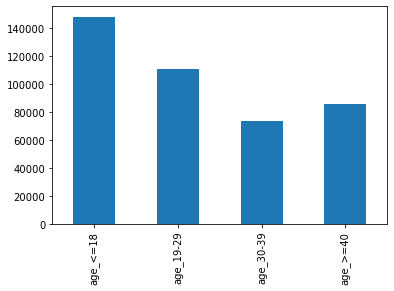

In [44]:
import pandas as pd
import numpy as np
import csv
df_random_sample_result_chunk = pd.read_csv('/home/chris/Downloads/m3inference/test/twitter_cache/random_twitter_sample_m3_result.csv',
     sep=',', 
     quotechar='"', 
     chunksize=100000,
    index_col=0)
df_random_sample_result = pd.concat(df_random_sample_result_chunk)
print(df_random_sample_result.shape)
#(463445, 9) - 463445 unique users post-m3inference in Sample A

##Now make new column with Organisational status labelled
conditions_org= [
    (df_random_sample_result['org_non-org'] > 0.5),
    (df_random_sample_result['org_non-org'] < 0.5),
    (df_random_sample_result['org_non-org'] == 0.5)
    ]
values_org= ['Non_org', 'Is_org', 'Non-Org_unclear']
df_random_sample_result['Org'] = np.select(conditions_org, values_org)
df_random_sample_result['Org'].value_counts()
#Non_org    418970
#Is_org      44475
#Remove Org from dataset:
df_random_sample_result_org = df_random_sample_result.loc[df_random_sample_result['Org'] == 'Is_org']
df_random_sample_result = df_random_sample_result.loc[df_random_sample_result['Org'] == 'Non_org']
df_random_sample_result.shape
#(418970, 12)
df_random_sample_result['Gender_total'] = df_random_sample_result['gender_male'] + df_random_sample_result['gender_female']
df_random_sample_result.Gender_total.sum()
#418969.9999062748 - hence all add up to 1
df_random_sample_result['Gender'] = np.where(df_random_sample_result.gender_male > 0.5, 'Male', 'Female')

#Calculate final numbers of Male vs Female for this random sample
df_random_sample_result.Gender.value_counts()
#Male      291662
#Female    127308
#Name: Gender, dtype: int64

##Calculate age
df_random_sample_result['Age'] = df_random_sample_result[['age_<=18','age_19-29', 'age_30-39', 'age_>=40']].idxmax(axis=1)
print('Sample 1 age distribution (all) \n', df_random_sample_result['Age'].value_counts())
#age_<=18     148377
#age_19-29    111051
#age_>=40      86119
#age_30-39     73423

df_random_sample_result.Age.value_counts().reindex(index = ['age_<=18', 'age_19-29', 'age_30-39', 'age_>=40']).plot.bar()

In [45]:
print('Sample 1 age distribution (by gender) \n', df_random_sample_result.groupby('Gender')['Age'].value_counts())

Sample 1 age distribution (by gender) 
 Gender  Age      
Female  age_<=18      47452
        age_19-29     43913
        age_30-39     20371
        age_>=40      15572
Male    age_<=18     100925
        age_>=40      70547
        age_19-29     67138
        age_30-39     53052
Name: Age, dtype: int64


<AxesSubplot:>

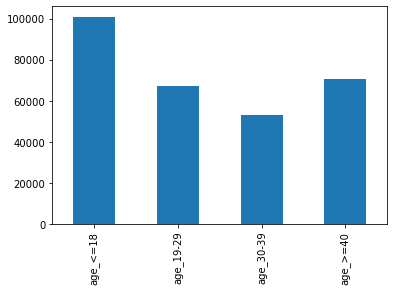

In [42]:
#Male age distribution, sample 1
df_random_sample_result_M = df_random_sample_result[df_random_sample_result['Gender'] == 'Male']
df_random_sample_result_M.Age.value_counts().reindex(index = ['age_<=18', 'age_19-29', 'age_30-39', 'age_>=40']).plot.bar()

<AxesSubplot:>

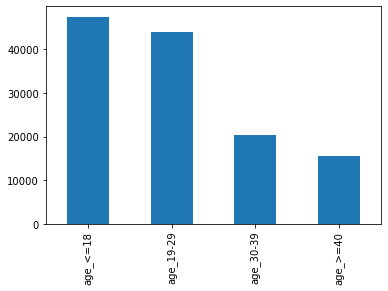

In [43]:
#Female age distribution, sample 1
df_random_sample_result_F = df_random_sample_result[df_random_sample_result['Gender'] == 'Female']
df_random_sample_result_F.Age.value_counts().reindex(index = ['age_<=18', 'age_19-29', 'age_30-39', 'age_>=40']).plot.bar()

### Sample B

(20050, 26)
Non_org    9836
Is_org     2166
Name: Org, dtype: int64
(9836, 10)
9835.999993989568
Male      5419
Female    4417
Name: Gender, dtype: int64
Sample 2 age distribution (all) 
 age_19-29    3850
age_>=40     2308
age_<=18     1949
age_30-39    1729
Name: Age, dtype: int64


<AxesSubplot:>

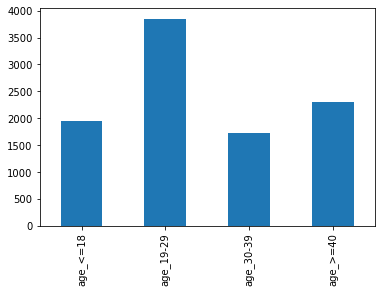

In [65]:
import pandas as pd
import numpy as np
import csv
dtypes = {'tweet_id' : str}
df_random_sample2_full_chunk = pd.read_csv('/home/chris/Downloads/m3inference/data-society-twitter-user-data/data/gender_classifier_dfe_791531.csv',
     sep=',', 
     quotechar='"', 
     dtype = dtypes,
     chunksize=100000)
df_random_sample2_full = pd.concat(df_random_sample2_full_chunk)
print(df_random_sample2_full.shape)
#(20050, 26)
df_random_sample2_result_chunk = pd.read_csv('/home/chris/Downloads/m3inference/test/twitter_cache2/random_twitter_sample2_m3_result.csv',
     sep=',', 
     quotechar='"', 
     chunksize=100000,
    index_col=0)
df_random_sample2_result = pd.concat(df_random_sample2_result_chunk)

##Now make new column with Organisational status labelled
conditions_org2= [
    (df_random_sample2_result['org_non-org'] > 0.5),
    (df_random_sample2_result['org_non-org'] < 0.5),
    (df_random_sample2_result['org_non-org'] == 0.5)
    ]
values_org2= ['Non_org', 'Is_org', 'Non-Org_unclear']
df_random_sample2_result['Org'] = np.select(conditions_org2, values_org2)
print(df_random_sample2_result['Org'].value_counts())
#Non_org    9836
#Is_org     2166

#Remove Org from dataset:
df_random_sample2_result_org = df_random_sample2_result.loc[df_random_sample2_result['Org'] == 'Is_org']
df_random_sample2_result = df_random_sample2_result.loc[df_random_sample2_result['Org'] == 'Non_org']
print(df_random_sample2_result.shape)
#(9836, 12)

df_random_sample2_result['Gender_total'] = df_random_sample2_result['gender_male'] + df_random_sample2_result['gender_female']
print(df_random_sample2_result.Gender_total.sum())
#9835.999993989568 - hence all add up to 1
df_random_sample2_result['Gender'] = np.where(df_random_sample2_result.gender_male > 0.5, 'Male', 'Female')

#Calculate final numbers of Male vs Female for this random sample
print(df_random_sample2_result.Gender.value_counts())
#Male      5419
#Female    4417
#Name: Gender, dtype: int64

##Calculate age
df_random_sample2_result['Age'] = df_random_sample2_result[['age_<=18','age_19-29', 'age_30-39', 'age_>=40']].idxmax(axis=1)
print('Sample 2 age distribution (all) \n', df_random_sample2_result['Age'].value_counts())
#aage_19-29    3850
#age_>=40     2308
#age_<=18     1949
#age_30-39    1729

df_random_sample2_result.Age.value_counts().reindex(index = ['age_<=18', 'age_19-29', 'age_30-39', 'age_>=40']).plot.bar()

Sample 2 age distribution (by gender) 
 Gender  Age      
Female  age_19-29    2139
        age_<=18      994
        age_30-39     723
        age_>=40      561
Male    age_>=40     1747
        age_19-29    1711
        age_30-39    1006
        age_<=18      955
Name: Age, dtype: int64


<AxesSubplot:>

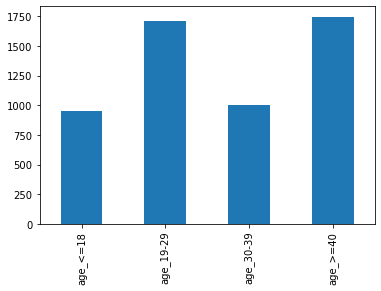

In [58]:
print('Sample 2 age distribution (by gender) \n', df_random_sample2_result.groupby('Gender')['Age'].value_counts())

#Male age distribution, sample 2
df_random_sample2_result_M = df_random_sample2_result[df_random_sample2_result['Gender'] == 'Male']
df_random_sample2_result_M.Age.value_counts().reindex(index = ['age_<=18', 'age_19-29', 'age_30-39', 'age_>=40']).plot.bar()

<AxesSubplot:>

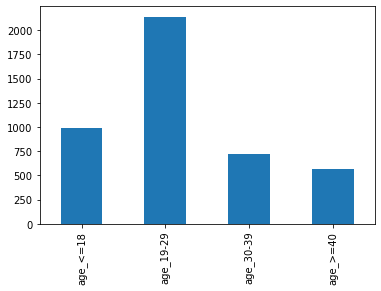

In [59]:
#Female age distribution, sample 2
df_random_sample2_result_F = df_random_sample2_result[df_random_sample2_result['Gender'] == 'Female']
df_random_sample2_result_F.Age.value_counts().reindex(index = ['age_<=18', 'age_19-29', 'age_30-39', 'age_>=40']).plot.bar()

### Sample C

Non_org    243567
Is_org      10803
Name: Org, dtype: int64
(243567, 10)
Male      148657
Female     94910
Name: Gender, dtype: int64
Sample 2 age distribution (all) 
 age_19-29    93588
age_>=40     62808
age_<=18     51971
age_30-39    35200
Name: Age, dtype: int64
Male      148657
Female     94910
Name: Gender, dtype: int64


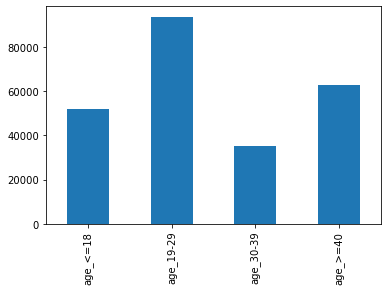

In [62]:
import pandas as pd
import numpy as np
import csv
dtypes = {'tweet_id' : str}

df_random_sample3_result_chunk = pd.read_csv('/home/chris/Downloads/m3inference/test/twitter_cache3/random_twitter_sample3_m3_result.csv',
     sep=',', 
     quotechar='"', 
     chunksize=100000,
    index_col=0)
df_random_sample3_result = pd.concat(df_random_sample3_result_chunk)
df_random_sample3_result.shape
#(254370, 9)

#And make new column with Organisational status labelled
conditions_org3= [
    (df_random_sample3_result['org_non-org'] > 0.5),
    (df_random_sample3_result['org_non-org'] < 0.5),
    (df_random_sample3_result['org_non-org'] == 0.5)
    ]
values_org3= ['Non_org', 'Is_org', 'Non-Org_unclear']
df_random_sample3_result['Org'] = np.select(conditions_org3, values_org3)
print(df_random_sample3_result['Org'].value_counts())
#Non_org    243567
#Is_org      10803

#Remove Org from dataset:
df_random_sample3_result_org = df_random_sample3_result.loc[df_random_sample3_result['Org'] == 'Is_org']
df_random_sample3_result = df_random_sample3_result.loc[df_random_sample3_result['Org'] == 'Non_org']
print(df_random_sample3_result.shape)
#(243567, 10)

df_random_sample3_result['Gender_total'] = df_random_sample3_result['gender_male'] + df_random_sample3_result['gender_female']
print(df_random_sample3_result.Gender_total.sum())
#418969.9999062748 - hence all add up to 1
df_random_sample3_result['Gender'] = np.where(df_random_sample3_result.gender_male > 0.5, 'Male', 'Female')

#Calculate final numbers of Male vs Female for this random sample
print(df_random_sample3_result.Gender.value_counts())
#Male      148657
#Female     94910
#Name: Gender, dtype: int64

##Calculate age
df_random_sample3_result['Age'] = df_random_sample3_result[['age_<=18','age_19-29', 'age_30-39', 'age_>=40']].idxmax(axis=1)
print('Sample 3 age distribution (all) \n', df_random_sample3_result['Age'].value_counts())
#age_19-29    93588
#age_>=40     62808
#age_<=18     51971
#age_30-39    35200

df_random_sample3_result.Age.value_counts().reindex(index = ['age_<=18', 'age_19-29', 'age_30-39', 'age_>=40']).plot.bar()

Sample 1 age distribution (by gender) 
 Gender  Age      
Female  age_19-29    44090
        age_<=18     19754
        age_>=40     16283
        age_30-39    14783
Male    age_19-29    49498
        age_>=40     46525
        age_<=18     32217
        age_30-39    20417
Name: Age, dtype: int64


<AxesSubplot:>

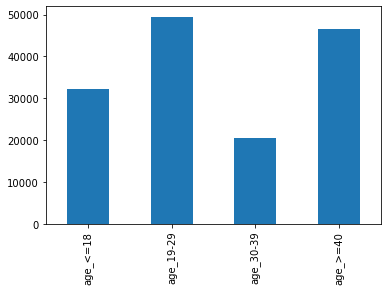

In [66]:
print('Sample 3 age distribution (by gender) \n', df_random_sample3_result.groupby('Gender')['Age'].value_counts())

#Male age distribution, sample 3
df_random_sample3_result_M = df_random_sample3_result[df_random_sample3_result['Gender'] == 'Male']
df_random_sample3_result_M.Age.value_counts().reindex(index = ['age_<=18', 'age_19-29', 'age_30-39', 'age_>=40']).plot.bar()

<AxesSubplot:>

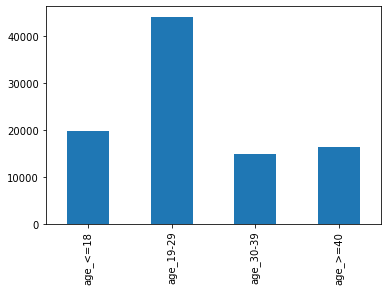

In [67]:
#Female age distribution, sample 3
df_random_sample3_result_F = df_random_sample3_result[df_random_sample3_result['Gender'] == 'Female']
df_random_sample3_result_F.Age.value_counts().reindex(index = ['age_<=18', 'age_19-29', 'age_30-39', 'age_>=40']).plot.bar()

In [72]:
df_random_sample3_result

,id,gender_male,gender_female,age_<=18,age_19-29,age_30-39,age_>=40,org_non-org,org_is-org,Org,Gender_total,Gender,Age
0,32633,0.957662,0.042338,0.198940,0.216733,0.077673,0.506654,0.956427,0.043573,Non_org,1.0,Male,age_>=40
1,58633,0.994824,0.005176,0.002350,0.023392,0.008525,0.965733,0.999200,0.000800,Non_org,1.0,Male,age_>=40
2,1329712436304367616,0.993533,0.006467,0.067450,0.343772,0.557309,0.031468,0.999614,0.000386,Non_org,1.0,Male,age_30-39
3,72373,0.999841,0.000159,0.148317,0.169658,0.311400,0.370624,0.987299,0.012701,Non_org,1.0,Male,age_>=40
4,1089806015674150912,0.983616,0.016384,0.000337,0.008192,0.990984,0.000487,0.999995,0.000005,Non_org,1.0,Male,age_30-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254365,1717118803,0.935609,0.064391,0.416085,0.180887,0.093277,0.309750,0.889678,0.110322,Non_org,1.0,Male,age_<=18
254366,1717118834,0.007965,0.992035,0.029445,0.044610,0.852129,0.073816,0.998768,0.001232,Non_org,1.0,Female,age_30-39
254367,1717130041,0.998745,0.001255,0.171536,0.372832,0.092794,0.362838,0.999288,0.000712,Non_org,1.0,Male,age_19-29
254368,1717165129,0.980356,0.019644,0.392645,0.212036,0.026512,0.368807,0.942812,0.057188,Non_org,1.0,Male,age_<=18


## Geolocation <a name="chapter10"></a>

In [1]:
import pandas as pd
dtypes_of_2={
        'created_at'  :  str,
        'id'  :  str,
        'id_str'  :  str,
        'full_text'  :  str,
        'truncated'  :  bool,
        'display_text_range'  :  str,
        'entities'  :  str,
        'source'  :  str,
        'in_reply_to_status_id'  :  str,
       'in_reply_to_status_id_str'  :  str,
       'in_reply_to_user_id'  :  str,
       'in_reply_to_user_id_str'  :  str,
       'in_reply_to_screen_name'  :  str,
       'user'  :  str, 
       'geo'  :  str,
       'coordinates'  :  str,
       'place'  :  str,
       'contributors'  :  str,
       'retweeted_status'  :  str,
       'is_quote_status'  :  str,
       'retweet_count'  :  int,
       'favorite_count'  :  int,
       'favorited'  :  bool,
       'retweeted'  :  bool,
       'lang'  :  str,
       'quoted_status_id'  :  str,
       'quoted_status_id_str'  :  str,
       'quoted_status_permalink'  :  str,
       'extended_entities'  :  str,
       'possibly_sensitive'  :  str,
       'withheld_in_countries'  :  str,
       'withheld_scope'  :  str,
       'withheld_copyright'  :  str,
       'quoted_status' : str
        }

df_orig1 = pd.read_csv('/home/chris/Downloads/tweet-ids-001/SarahEverard/Data/Hydrated_JSONL/Hydrator_out/SarahEverard_hydrated.csv', sep=',', quotechar='"',dtype = dtypes_of_2)
df_orig2 = pd.read_csv('/home/chris/Downloads/tweet-ids-001/SarahEverard/Data/Hydrated_JSONL/Hydrator_out/prehydrated_missing_tweets_hydrated.csv', sep=',', quotechar='"',dtype = dtypes_of_2)
df_orig3 = pd.read_csv('/home/chris/Downloads/tweet-ids-001/SarahEverard/Data/Hydrated_JSONL/Hydrator_out/df_missing_10_Mar_RT_hydrated.csv', sep=',', quotechar='"',dtype = dtypes_of_2)

df_orig = pd.concat([df_orig1 ,df_orig2, df_orig3])

pd.set_option('display.max_columns', None)
df_users = df_orig.drop_duplicates(subset = ['user_screen_name'], keep = 'first')

del df_orig
del df_orig1
del df_orig2
del df_orig3

/home/chris/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
print(df_users[['coordinates', 'place', 'user_location']].notnull().sum())
print("\nInstances where user_location not provided but coordinates are:", (df_users['coordinates'].notnull() & df_users['user_location'].isnull()).sum())
print("Instances where user_location not provided by 'place' is:", (df_users['place'].notnull() & df_users['user_location'].isnull()).sum())

coordinates          70
place              2150
user_location    291840
dtype: int64

Instances where user_location not provided but coordinates are: 4
Instances where user_location not provided by 'place' is: 220


In [21]:
df_users_location = df_users[['user_location']]
print(df_users_location.shape)
df_users_location = df_users_location.drop_duplicates(subset = 'user_location')
print(df_users_location.shape)

(422200, 1)
(90466, 1)


#### Mordecai geolocation

In [ ]:
##Import Mordecai results:
import pandas as pd
df_Mordercai_loc_combined = pd.read_csv('/home/chris/Downloads/tweet-ids-001/SarahEverard/df_Mordercai_loc_combined_120822.csv', sep=',', quotechar='"', index_col=0)

df_Mordercai_place_combined = pd.read_csv('/home/chris/Downloads/tweet-ids-001/SarahEverard/df_Mordercai_place_combined_120822.csv', sep=',', quotechar='"', index_col=0)
df_Mordercai_place_combined = df_Mordercai_place_combined.drop(columns = ['user_name'])
df_Mordercai_place_combined = df_Mordercai_place_combined.rename(columns = {'user_screen_name': 'user_screen_name_place'})
df_Mordercai_place_combined = df_Mordercai_place_combined.drop_duplicates(subset='place')

#Now merge selected columns with df_Mordercai_loc_combined
df_users_merged = df_users[['user_screen_name', 'user_name', 'user_location', 'place']].merge(df_Mordercai_loc_combined, on = 'user_location', how = 'left')
df_users_merged.shape
#(422200, 46)
df_users_merged = df_users_merged.merge(df_Mordercai_place_combined, on = 'place', how = 'left')
df_users_merged.shape
#(422200, 68)
#df_users_merged.to_csv('/home/chris/Downloads/tweet-ids-001/SarahEverard/df_users_Mordercai_120822.csv', sep=',', quotechar='"')

In [8]:
##Now merge df_users_merged with df_harass_selected_demog_VADER_NRC
df_users_merged['screen_name'] = df_users_merged['user_screen_name']
df_harass_selected_demog_VADER_NRC = df_harass_selected_demog_VADER_NRC.merge(df_users_merged, on = 'screen_name', how = 'left')

df_harass_selected_demog_VADER_NRC.shape
#(894119, 119)

/home/chris/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,26,27,28,29,33,34,35,36,40,41,42,43,47,48,49,50,51,55,56,57,58,62,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(894119, 119)

In [9]:
###Now lets' start interrogating the data:
#What is the difference between country_predicted and country_code3:
print(df_harass_selected_demog_VADER_NRC['country_predicted_loc_0'].isnull().sum())
#449904
print(df_harass_selected_demog_VADER_NRC['country_code3_loc_0'].isnull().sum())
#530917

pd.set_option('display.max_rows', 250)
df_harass_selected_demog_VADER_NRC[(df_harass_selected_demog_VADER_NRC['country_predicted_loc_0'].notnull() & df_harass_selected_demog_VADER_NRC['country_code3_loc_0'].isnull())].sample(100)
#Broadly, country_predicted is correct and should be used

print((df_harass_selected_demog_VADER_NRC['user_location'] == 'Streatham, London').sum())
#62 from Streatham, London are labelled as USA
print((df_harass_selected_demog_VADER_NRC['user_location'] == 'Norfolk, United Kingdom').sum())
#24 from Norfolk, United Kingdom labelled as USA

#There are some errors, e.g Los Angeles, CA -> MEX and San Francisco, CA -> GTM!

print(df_harass_selected_demog_VADER_NRC.shape)
#(894119, 119)
print(df_harass_selected_demog_VADER_NRC['user_location'].notnull().sum())
#621158
print(df_harass_selected_demog_VADER_NRC['country_predicted_loc_0'].notnull().sum())
#444215

print(df_harass_selected_demog_VADER_NRC['country_code3_loc_0'].notnull().sum())
#363202

print(df_harass_selected_demog_VADER_NRC['place_name_loc_0'].notnull().sum())
print(df_harass_selected_demog_VADER_NRC['lat_loc_0'].notnull().sum())
print(df_harass_selected_demog_VADER_NRC['long_loc_0'].notnull().sum())
#365103 for all

print(df_harass_selected_demog_VADER_NRC['country_predicted_loc_0'].value_counts())


449904
530917
62
24


In [12]:
places = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['place'].notnull()]
places = places[['created_at', 'id', 'user_id_str', 'screen_name', 'name', 'user_location', 'place', 'country_predicted_loc_0', 'output_place_0', 'country_predicted_place_0']]
print(places.shape)
#(4820, 10)
#Find out how many times the (places vs location) country prediction differs:
print((places['country_predicted_loc_0'] == places['country_predicted_place_0']).sum())
#2592
places[places['country_predicted_loc_0'] != places['country_predicted_place_0']]
#Upon manual inspection, it appears reasonable to extract location data:
#1) country_predicted_loc_0, then if country_predicted_loc_0=nan, extract country_predicted_place_0

#To achieve this, make final column first from 'country_predicted_loc_0'
df_harass_selected_demog_VADER_NRC['country_predicted_final'] = df_harass_selected_demog_VADER_NRC['country_predicted_loc_0']
#Then populate nan in country_predicted_final with country_predicted_place_0
df_harass_selected_demog_VADER_NRC.country_predicted_final.fillna(df_harass_selected_demog_VADER_NRC.country_predicted_place_0, inplace = True)

drop_columns = ['country_code3_loc_0', 'country_conf_loc_0',  'lat_loc_0',  'long_loc_0',
 'output_loc_1',  'place_name_loc_1',  'country_predicted_loc_1',  'country_code3_loc_1', 
 'country_conf_loc_1',  'lat_loc_1',  'long_loc_1',  'output_loc_2',  'place_name_loc_2',
 'country_predicted_loc_2',  'country_code3_loc_2',  'country_conf_loc_2',  'lat_loc_2',
 'long_loc_2',  'output_loc_3',  'place_name_loc_3',  'country_predicted_loc_3',  'country_code3_loc_3',
 'country_conf_loc_3',  'lat_loc_3',  'long_loc_3',  'output_loc_4',  'place_name_loc_4',  'country_predicted_loc_4',
 'country_code3_loc_4',  'country_conf_loc_4',  'lat_loc_4',  'long_loc_4',  'output_loc_5',  'place_name_loc_5',
 'country_predicted_loc_5',  'country_code3_loc_5',  'country_conf_loc_5',  'lat_loc_5',  'long_loc_5',
 'user_screen_name_place', 'place_name_place_0', 'country_code3_place_0',  'country_conf_place_0',
 'lat_place_0',  'long_place_0',  'output_place_1',  'place_name_place_1',  'country_predicted_place_1',
 'country_code3_place_1',  'country_conf_place_1',  'lat_place_1',  'long_place_1',  'output_place_2',  'place_name_place_2',
 'country_predicted_place_2',  'country_code3_place_2', 'country_conf_place_2',  'lat_place_2',  'long_place_2']
df_harass_selected_demog_VADER_NRC = df_harass_selected_demog_VADER_NRC.drop(columns = drop_columns)

In [121]:
##Now can analyse the final country_predictions:
n_location = df_harass_selected_demog_VADER_NRC['country_predicted_final'].notnull().sum()
print('Tweets with location data available:', n_location)
df_location_value_counts = pd.DataFrame(df_harass_selected_demog_VADER_NRC['country_predicted_final'].value_counts())
df_location_value_counts['percent'] = df_location_value_counts['country_predicted_final'] / n_location * 100
df_location_value_counts.head(10)

Tweets with location data available: 444215


,country_predicted_final,percent
GBR,336251,75.695553
USA,45637,10.273629
CAN,9668,2.176424
AUS,8042,1.810385
IRL,6824,1.536193
FRA,3038,0.683903
DEU,2629,0.591831
ESP,1758,0.395754
IND,1530,0.344428
ZAF,1396,0.314262


In [160]:
print(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['country_predicted_final'] == 'GBR']['user_location'].value_counts().head(10), '\n')
print(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['country_predicted_final'] == 'USA']['user_location'].value_counts().head(10), '\n')
print(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['country_predicted_final'] == 'CAN']['user_location'].value_counts().head(10), '\n')
print(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['country_predicted_final'] == 'AUS']['user_location'].value_counts().head(10), '\n')
print(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['country_predicted_final'] == 'IRL']['user_location'].value_counts().head(10), '\n')
print(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['country_predicted_final'] == 'FRA']['user_location'].value_counts().head(10), '\n')
print(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['country_predicted_final'] == 'DEU']['user_location'].value_counts().head(10), '\n')
print(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['country_predicted_final'] == 'ESP']['user_location'].value_counts().head(10), '\n')
print(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['country_predicted_final'] == 'IND']['user_location'].value_counts().head(10), '\n')
print(df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['country_predicted_final'] == 'ZAF']['user_location'].value_counts().head(10), '\n')

London, England             43056
London                      31115
United Kingdom              16280
England, United Kingdom     15434
UK                          10464
Manchester, England          5191
Glasgow, Scotland            4842
England                      4784
Scotland, United Kingdom     4191
London, UK                   3838
Name: user_location, dtype: int64 

United States      2305
Los Angeles, CA    1302
California, USA    1075
USA                 931
New York, NY        872
Chicago, IL         585
Washington, DC      566
Texas, USA          525
New York, USA       502
Seattle, WA         379
Name: user_location, dtype: int64 

Canada                         1472
Toronto, Ontario                928
Toronto                         438
Ontario, Canada                 376
Vancouver, British Columbia     250
Montréal, Québec                143
Toronto, Canada                 141
Ottawa, Ontario                 138
British Columbia, Canada        128
Halifax, England        

In [119]:
##Manually amend locations from the top 10 countries which have been incorrectly parsed:

#Change to GBR country code
countrycode_to_GBR = ['Northampton, England', 'North Wales', 'York, England', 'South Wales',
                      'Burton upon Trent, England', 'Newcastle Upon Tyne, England', 'Newcastle upon Tyne',
                      'Newcastle', 'South East England', 'Newcastle, England', 'newcastle', 'newcastle upon tyne',
                      'Newcastle-under-Lyme, England', 'Newcastle, UK', 'East East East London', 'Newcastle upon Tyne, UK',
                      'Newcastle-upon-Tyne', 'Newcastle Upon Tyne', 'South East England.  ', 'Newcastle upon tyne England',
                     'uk', 'Uk', 'Newcastle ', 'Newcastle Upon Tyne UK', 'Surreyshire in Little England']

for country in countrycode_to_GBR:
    df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['user_location'] == country, 'country_predicted_final'] = 'GBR'
    
#Change to USA country code
countrycode_to_USA = [
    'Brooklyn, NY', 'Los Angeles, CA', 'Los Angeles', 'San Antonio, TX',
    'Santa Rosa, CA', 'Los Angeles, California', 'los angeles', 'San Antonio, Texas', 'Palo Alto, CA', 'Los Angeles',
    'California, USA', 'California', 'Southern California', 'Cali', 'california'
]

for country in countrycode_to_USA:
    df_harass_selected_demog_VADER_NRC.loc[df_harass_selected_demog_VADER_NRC['user_location'] == country, 'country_predicted_final'] = 'USA'

In [155]:
##Examine location by gender
df_male = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['Gender']=='Male']
df_female = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['Gender']=='Female']

def make_value_counts(df):
    n_location = df['country_predicted_final'].notnull().sum()
    print('Number of Tweets with location data:', n_location)
    print('Number of Tweets in total:', len(df))
    print('Percentage of Tweets with location data:', (n_location/len(df)*100))
    df_location_value_counts = pd.DataFrame(df['country_predicted_final'].value_counts())
    df_location_value_counts['percent'] = df_location_value_counts['country_predicted_final'] / n_location * 100
    print(df_location_value_counts.head(10), '\n')
    return  df_location_value_counts

df_male_location_counts = make_value_counts(df_male)
df_female_location_counts = make_value_counts(df_female)

#Hence, similar geolocation between genders

Number of Tweets with location data: 169239
Number of Tweets in total: 349822
Percentage of Tweets with location data: 48.37860397573623
     country_predicted_final    percent
GBR               126040      74.474560
USA                16913       9.993559
CAN                 3565       2.106488
AUS                 3021       1.785050
IRL                 2083       1.230804
FRA                 1369       0.808915
DEU                 1286       0.759872
IND                 1014       0.599153
ESP                  834       0.492794
ZAF                  668       0.394708 

Number of Tweets with location data: 274976
Number of Tweets in total: 544297
Percentage of Tweets with location data: 50.51947741765984
     country_predicted_final    percent
GBR               210211      76.447035
USA                28724      10.446003
CAN                 6103       2.219466
AUS                 5021       1.825978
IRL                 4741       1.724150
FRA                 1669       0.606962
DEU 

In [139]:
##Examine location by topic:
#N.B - need to run the code in LDA topic modelling section until before creation of topic_1_tweets
#to generate df_harass_selected_demog_VADER_NRC_summary_classified
df_topics_all = df_harass_selected_demog_VADER_NRC_summary_classified[['id', 'datetime', 'Dominant_Topic', 'Dominant_Topic_prev']]
df_harass_selected_demog_VADER_NRC = df_harass_selected_demog_VADER_NRC.merge(df_topics_all, on = 'id', how = 'left')
df_harass_selected_demog_VADER_NRC.shape
#(894119, 65)

topic_1_tweets_location = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['Dominant_Topic_prev']=='1']
topic_2_tweets_location = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['Dominant_Topic_prev']=='2']
topic_3_tweets_location = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['Dominant_Topic_prev']=='3']
topic_4_tweets_location = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['Dominant_Topic_prev']=='4']
topic_5_tweets_location = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['Dominant_Topic_prev']=='5']
topic_6_tweets_location = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['Dominant_Topic_prev']=='6']
topic_7_tweets_location = df_harass_selected_demog_VADER_NRC[df_harass_selected_demog_VADER_NRC['Dominant_Topic_prev']=='7']


'''Ordered by prevalence

Topic 1 [0] – ‘Not safe walking home’:
    • (0, '0.042*"woman" + 0.038*"not" + 0.026*"saraheverard" + 0.025*"sarah" + 0.023*"everard" + 0.021*"man" + 0.017*"walk" + 0.014*"home" + 0.010*"feel" + 0.010*"safe"')
    • 41% of tokens

Topic 2 [3] – ‘Sarah Everard murdered’:
    • (3, '0.024*"not" + 0.022*"saraheverard" + 0.022*"police" + 0.018*"sarah" + 0.017*"everard" + 0.012*"woman" + 0.010*"murder" + 0.008*"people" + 0.008*"metpoliceuk" + 0.008*"no"')
    • 20.8% of tokens	

Topic 3 [2] – ‘Police officer arrested’:
    • (2, '0.073*"police" + 0.070*"sarah" + 0.069*"everard" + 0.047*"officer" + 0.040*"arrest" + 0.024*"vigil" + 0.024*"met" + 0.023*"disappearance" + 0.019*"murder" + 0.017*"london"')
    • 15.6% of tokens	

Topic 4 [5] – ‘Sarah Everard vigil, peaceful protest’:
    • (5, '0.066*"vigil" + 0.051*"protest" + 0.049*"peaceful" + 0.038*"saraheverard" + 0.029*"woman" + 0.021*"not" + 0.018*"uk" + 0.018*"policing" + 0.018*"would" + 0.018*"need"')	
    • 8.3% of tokens

Topic 5 [4]– ‘Thoughts with Sarah Everard’s friends & family’:
    • (4, '0.065*"sarah" + 0.053*"everard" + 0.052*"family" + 0.021*"friend" + 0.018*"saraheverard" + 0.012*"pay" + 0.012*"thought" + 0.011*"love" + 0.010*"peace" + 0.010*"kate"')	
    • 6.5% of tokens

Topic 6 [1] – ‘Missing Wednesday 3 March, please share’: 
    • (1, '0.022*"saraheverard" + 0.016*"please" + 0.011*"march" + 0.010*"clapham" + 0.010*"share" + 0.008*"brixton" + 0.008*"3" + 0.007*"wednesday" + 0.007*"miss" + 0.007*"information"')	
    • 3.5% of tokens

Topic 7 [6] – ‘Tigray genocide’:
    • (6, '0.039*"saraheverard" + 0.033*"tigraygenocide" + 0.032*"mothersday" + 0.031*"tigraymothers" + 0.030*"tigray" + 0.029*"metoo" + 0.026*"un" + 0.023*"violenceagainstwomen" + 0.022*"rape" + 0.016*"bwoodward"')
    • 4.4% of tokens

'''

Index(['index', 'created_at', 'id', 'full_text', 'source', 'is_quote_status',
       'retweeted_status', 'retweet_count', 'favorite_count', 'user_id_str',
       'screen_name', 'name', 'description', 'hashtags_all', 'gender_male',
       'gender_female', 'age_<=18', 'age_19-29', 'age_30-39', 'age_>=40',
       'org_non-org', 'org_is-org', 'Gender', 'Org', 'Age', 'text_banned',
       'full_text_VADER', 'text_neg', 'text_neu', 'text_pos', 'text_compound',
       'text_banned_neg', 'text_banned_neu', 'text_banned_pos',
       'text_banned_compound', 'full_text_all', 'RT_full_text',
       'RT_full_text_VADER', 'emotion', 'Major_emotion', 'Major_emotion_emot',
       'anger_rel_emot', 'anticipation_rel_emot', 'disgust_rel_emot',
       'fear_rel_emot', 'joy_rel_emot', 'sadness_rel_emot',
       'surprise_rel_emot', 'trust_rel_emot', 'index', 'emotion_label',
       'user_screen_name', 'user_name', 'user_location', 'place',
       'output_loc_0', 'place_name_loc_0', 'country_predicted_loc_

In [154]:
def make_value_counts(df):
    n_location = df['country_predicted_final'].notnull().sum()
    print('Number of Tweets with location data:', n_location)
    print('Number of Tweets in total:', len(df))
    print('Percentage of Tweets with location data:', (n_location/len(df)*100))
    df_location_value_counts = pd.DataFrame(df['country_predicted_final'].value_counts())
    df_location_value_counts['percent'] = df_location_value_counts['country_predicted_final'] / n_location * 100
    print(df_location_value_counts.head(10), '\n')
    return  df_location_value_counts

df_topic_1_tweets_location_count = make_value_counts(topic_1_tweets_location)
df_topic_2_tweets_location_count = make_value_counts(topic_2_tweets_location)
df_topic_3_tweets_location_count = make_value_counts(topic_3_tweets_location)
df_topic_4_tweets_location_count = make_value_counts(topic_4_tweets_location)
df_topic_5_tweets_location_count = make_value_counts(topic_5_tweets_location)
df_topic_6_tweets_location_count = make_value_counts(topic_6_tweets_location)
df_topic_7_tweets_location_count = make_value_counts(topic_7_tweets_location)


Number of Tweets with location data: 226218
Number of Tweets in total: 450656
Percentage of Tweets with location data: 50.19748988141731
     country_predicted_final    percent
GBR               170779      75.493108
USA                24081      10.645042
CAN                 4960       2.192575
IRL                 4331       1.914525
AUS                 4122       1.822136
FRA                 1408       0.622408
DEU                 1311       0.579529
ESP                  794       0.350989
IND                  681       0.301037
ZAF                  669       0.295732 

Number of Tweets with location data: 76430
Number of Tweets in total: 157643
Percentage of Tweets with location data: 48.482964673344206
     country_predicted_final    percent
GBR                61668      80.685595
USA                 6079       7.953683
AUS                 1232       1.611932
CAN                 1150       1.504645
IRL                  803       1.050635
FRA                  585       0.765406
ESP 

In [29]:
##The code for Geolocation of random Samples A, B and C can be found in files:
#SV_rsampleA_geolocation_Mordecai_120822.py
#SV_rsampleB_geolocation_Mordecai_120822.py
#SV_rsampleC_geolocation_Mordecai_120822.py